# Sentiment Analysis 2020 Election Tweets

# Project 1

## **Research Question:** *Quantifying public engagement toward political parties on twitter to predict election results*

### Introduction 
##### Social media platforms like Facebook and Twitter have entirely altered how we share news and opinions regarding current affairs. Twitter is an integral part of the mainstream media and has allowed it to become a platform for electoral campaigning. Influential individuals and organizations including politicians and political parties have increased the use of Twitter to change public sentiment regarding current affairs. During the 2020 US presidential election campaign, millions of tweets were posted by users around the world. Fortunately, we have access to detailed information regarding these tweets. 
##### The data used in this particular research consist of the two primary election candidates, Donald Trump, and Joe Biden. We have separate data sets of tweets that contain their names. The tweet data was accessed from Kaggle which has been collected since October 2020 for approximately one month till the election month of November 2020. There are many tools to measure the popularity of someone on platforms like Twitter. For instance, the number of tweets for each candidate could demonstrate their number of supporters. Similarly, the public engagement on these tweets like the number of retweets would indicate how well-known a particular tweet is. Similarly, the number of likes on a particular tweet is a prime variable to measure the popularity of a tweet and whether people support a particular message or not. Moreover, the location origin of a tweet is of utmost importance since that would indicate whether the tweet count of a specific state within the US eventually dictates a relation between the real vote counts of the mentioned state and its ultimate result.
##### Unfortunately, the nature of tweets is ambiguous since it represents emotions and so, we must identify and categorize them. To analyze whether these opinions are in support or against the candidates, in this case, Biden or Trump, a sentiment analysis would be the right approach. The goal of sentiment analysis is to understand the opinions of people. It analyzes emotions, opinions, and attitudes towards issues and uses natural language processing and machine learning techniques to automatically identify subjective information from text data and then categorize it into positive, negative, or neutral sentiments. 
##### After working with the data, we observed how the likes, retweet counts, and user follower counts of tweets were positively related to the vote counts of most states in the United States. It is very important to realize that we hypothesized that tweets with positive sentiments or emotions would have a positive correlation with vote counts in general. Our plots and figures indeed affirmed the hypotheses since the plots had a direct relation to the variables.
##### When keeping the plots side by side for each candidate, we observed how a weaker association in our regression meant a higher public engagement on the social media platform. We saw that Biden for all our independent variables had a much higher public engagement. This can be because our data set contains a much larger number of tweets that relates to Biden when compared to the number of tweets Trump had. 
##### Moreover, we mapped the the mean positive and negative sentiment scores for the tweets by state for each candidate, Trump and Biden. It did uphold our expectations as we expected, a high positive score for a candidate would suggest that they would win in that state. Similarly, a high average negative sentiment in a state for a candidate eventually meant that we would expect a loss for them. Though this was true in many cases, there were some outlier states in both the instances. This is consistent with the election results as well where Biden won in most sates becoming the next President of the United States of America.


In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import random
import re # importing regex to filter tweets
import nltk # improting natural language tool kit which contains the sentiment analyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
# analyzer in the pre-built vader model to detect text polarity
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
import plotly.express as px
import plotly.graph_objs as go
import collections
import geopandas as gpd
from shapely.geometry import Point

## Data Loading and Wrangling

##### Reading the csv files for both the election candidates, Donald Trump and Joe Biden

In [339]:
dft = pd.read_csv(r'C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\hashtag_donaldtrump.csv', lineterminator = '\n')

In [340]:
dfb = pd.read_csv(r'C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\hashtag_joebiden.csv', lineterminator = '\n')

##### Concatenating/combining both the Donald Trump and Joe Biden Data Sets 

In [341]:
# We add a new column of the candidate name to both the data sets to keep them distinct
dft["Candidate Name"] = "Donald Trump"
dfb["Candidate Name"] = "Joe Biden"
trump_biden_data = pd.concat([dft, dfb]) # We now merge or concatenate both the data sets


##### We check the countries from where the tweets have been collected by the author of the data sets

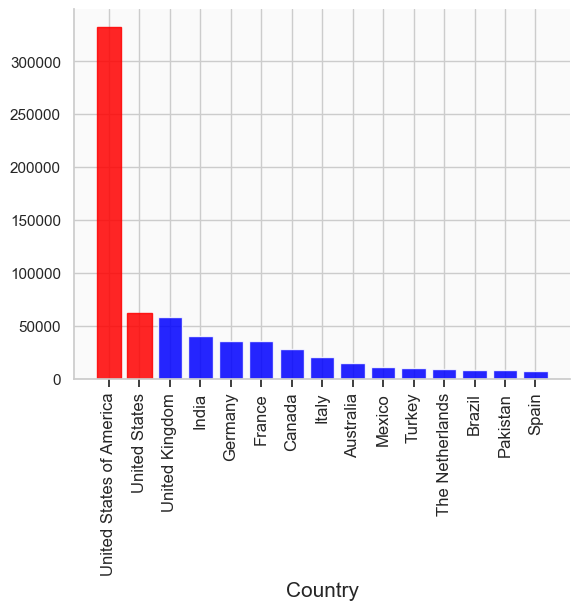

In [342]:
name_check = pd.DataFrame(data = trump_biden_data.groupby('country')['tweet'].count().sort_values(ascending=False).head(15))
name_check = name_check.reset_index()
ax = plt.bar(x = 'country', height = 'tweet', color = 'blue', alpha = 0.85, data = name_check)
ax[0].set_color('red')
ax[1].set_color('red')
plt.xlabel('Country', fontsize = 15)
plt.xticks(rotation=90)
sns.despine()
sns.set_theme(rc = {'xtick.labelsize' : 12.0})
sns.set_style('white')

##### We observe that there are tweets from other countries apart from the US so we further clean the country column and only keep the tweets which are from the US. Moreover, observe that the first two bars both represents tweets from the USA so, we must keep both of them as one country

In [343]:
trump_biden_data = trump_biden_data.loc[(trump_biden_data['country'] == "United States") | (trump_biden_data['country'] == "United States of America")] 
trump_biden_data.isna().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                      20
user_id                      0
user_name                    1
user_screen_name             0
user_description         23618
user_join_date               0
user_followers_count         0
user_location                0
lat                          0
long                         0
city                    201791
country                      0
continent                    0
state                    61933
state_code               61933
collected_at                 0
Candidate Name               0
dtype: int64

In [344]:
trump_biden_data = trump_biden_data[(trump_biden_data['state'] != 'Guam')]
trump_biden_data = trump_biden_data[(trump_biden_data['state'] != 'Puerto Rico')]

##### After all the data wrangling we finally check whether if there are any important columns that contains the NaN values so we could remove them as well. Since, state name is an integral part of the research question we remove all the tweets that does not contain the state name. Note that although city and user description have NaN values, we still keep those tweets as they do not hinder our research. 

In [345]:
trump_biden_data = trump_biden_data.dropna(subset = 'state') # we remove the tweets with na values in the state column

##### There can be numerous tweets that can be in both the data sets given that there is a possibilty that tweets may contain both Biden and Trump names. We have to account for the repeated tweets after both the sets were concatenated and remove them

In [346]:
trump_biden_data = trump_biden_data.drop_duplicates(subset = 'tweet', keep = False)

##### Lastly, we must remove all the tweets that were tweeted after the election poll that was held on November 3rd 2020. We would only account tweets that were tweeted prior the actual election to accurately predict the election results

In [347]:
trump_biden_data = trump_biden_data.loc[(trump_biden_data['created_at'] < '2020-11-03 24:00:00')] # only keeps the observations until the day of election which was November 3rd 2020

##### To further progress in the project, identifying sentiment state for each tweet was crucial. For that purpose, the tweet data had to be heavily cleaned because the sentiment analyzer which we will be working with only allows plain text data. Unfortunately, our tweet messages were far from clean and contained a lot of data which was not acceptable to the analyzer. For this purpose regex (regular expressions) was imported to clean each tweet in the combined data set.

##### The following code cleans the tweet messages very carefully and leaves us with a clean and plain textual sentence. We define a function that takes in a string of characters. It then turns every letter into lower case. It then removes all the apostrophes from the string, removes # hashtags in the beginning, middle or at the end of a tweet. Similarly, it removes the @ mentions in a similar way that maybe used inside a tweet. The function then removes any sort of punctuations including commas, question mark and exclamation mark. Furthermore, it removes any mentioned links and websites that starts with 'https'. It then splits all the words into a list to check for stop words from a pre-specified list and remove them respectively from the list. Stop words are words in a sentence that are of no importance and which does not bring any new meaning to the message. Once stop words are removed from the list of words, they are then joined back again as a sentence ready for further analysis.

In [348]:
stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from",
"put", "rather", "said", "same", "ask", "about"] # randomly made a list of some words considered to be unuseful
def clean_tweet(tweet):
    clean = tweet.lower() # lowercasing all the letters in the tweet
    clean = re.sub("'", "", clean) # removing ' from tweets
    clean = re.sub("#[A-Za-z0-9_]+","", clean) # removing hashtags 
    clean = re.sub("@[A-Za-z0-9_]+","", clean) # removing mentions
    clean = re.sub('[()!?]', ' ', clean) # removing punctuations including commas, 
                                       # exclamation marks question marks etc
    clean = re.sub('\[.*?\]',' ', clean) 
    clean = re.sub(r'http\S+', '', clean) # removing any website links
    clean = re.sub("[^a-z0-9]"," ", clean) # removes all non-alphabetic 
                                         #letters and keeps alphabetic and numbers 
    clean = clean.split() # splits the tweet string into a list
    clean = [word for word in clean if not word in stopwords] # comprehension to remove any stopwords from the list
    clean = " ".join(word for word in clean) # joins back all the words from the list as a sentece
    return clean
  

##### We now create a new column in our data set for the cleaned tweet and apply our defined function on every tweet in our data set. 

In [349]:
trump_biden_data['clean'] = trump_biden_data['tweet'].apply(lambda x: clean_tweet(x))  

##### In this project, the use of a lexicon based sentimental analysis is done through VADER (Valence Aware Dictionary and Sentiment Reasoner) which automatically identifies the sentiment of a text based on words and slangs. The function SentimentIntensityAnalyzer is present in the natural language toolkit (NLTK) of python that takes in our cleaned data.

##### We now apply the pre-defined sentiment intensity analyzer function on our cleaned tweets. We created a new column for the polairty score for each tweet. This simply calculates the polarity scores of each tweet between negative, neutral and positive. We then observe the compund score, the addition of all scores of the three categories. If the compound is closer to +1 then the tweet is positive while if it is closer to -1 then it would be considered negative. 

In [350]:
sent_analyzer = SentimentIntensityAnalyzer() # assigning the analyzer to a variable
trump_biden_data['polarity_score'] = trump_biden_data['clean'].apply(lambda x: sent_analyzer.polarity_scores(x))
# creating the sentiment column and using the analyzer on the cleaned tweets to calculate polarity scores

##### The compound score is being categorized between positive, neutral or negative. As mentioned before, a positive compound score will be considered a positive tweet and any compound score that is negative will be considered negative tweet. 

In [351]:
def emotion_state(sentiment_score):
  """
  This function takes in the sentiment score values and identifies what emotion does the score refers to
  between the 3 general states of Positive, Negative and Neutral 
  """
  if sentiment_score['compound'] >= 0.05: # creating a threshold of positive tweets for the polarity scores 
    return "Positive"
  elif sentiment_score['compound'] <= -0.05: # creating a threshold of negative tweets for the polarity scores
    return "Negative"
  else:
    return "Neutral" 


##### This is the most important part of our code to continue our analysis. We pick all the tweets that has a positive sentiment. As mentioned in the introduction we assumed that the all engagement on positive tweets should have a positive relationship with the vote counts of a particular state. 
##### Note that this dataset still contains both the candidates' tweets.

In [352]:
trump_biden_data['Sentiment'] = trump_biden_data['polarity_score'].apply(lambda x: emotion_state(x)) # applying the function and categorozing each tweet in the data set

In [353]:
only_positive = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Positive']
only_negative = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Negative']

##### The following code reads the data from the Election Results Data set. This is the president county data set with the candidate names along with it. After reading the csv file, we only kept the observations with Joe Biden and Donald Trump and remove all other candidates. We then categorized the data set with state and candidate and changed the column name for merging purposes.

In [354]:
results = pd.read_csv(r"C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\president_county_candidate.csv")
results = results.loc[(results['candidate'] == "Joe Biden") | (results['candidate'] == 'Donald Trump')]
tvbs = results.groupby(['state', 'candidate']).sum('total_votes')
tvbs = tvbs.reset_index()
tvbs.rename(columns = {'candidate':'Candidate Name'}, inplace = True)


##### We now merge our dataset (tvbs) that contains total votes by state with the data frames with only positive tweets and only negative tweets respectively. We calculated the averages of our independent variables likes likes and retweet counts in those states from the new data frames.  

In [355]:
merge_pos_vote = pd.merge(only_positive, tvbs, on = ['state', 'Candidate Name'])
mean_pos_table = merge_pos_vote.groupby('state').mean()
merge_neg_vote = pd.merge(only_negative, tvbs, on = ['state', 'Candidate Name'])
mean_neg_table = merge_neg_vote.groupby('state').mean()

## Summary Statistics Tables

##### The following summary statistics table shows detailed information regarding retweets of the tweets that mentions both the election candidates, Joe Biden and Donald Trump. Firstly, note that the number of observations for Biden is much lower than Trump's. Yet, we see that the mean retweet for Joe Biden is higher than Donald Trump. This is because there are more retweets of the tweets with Biden mentioned than Trump. Moreover, the maximum number of retweets on a single tweet relating to Joe Biden is 3 times larger than of the maximum from the tweets which mentions Trump. This significance further shows to be true since the standard deviation of the retweets of Biden is double of that of Trump's meaning that the retweets are more spread out and much far from the mean when compared to Trump's retweet data. This shows high variability of retweet counts in tweets relating to Biden. It is evident through the retweets that Biden's message and campaign is more cirulating and much stornger.

In [356]:
trump_biden_data.groupby('Candidate Name')["retweet_count"].sum()

Candidate Name
Donald Trump    212546.0
Joe Biden       267398.0
Name: retweet_count, dtype: float64

In [357]:
trump_biden_data.groupby('Candidate Name')["retweet_count"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104155.0,2.040670,42.554416,0.0,0.0,0.0,0.0,5986.0
Joe Biden,76632.0,3.489378,85.341246,0.0,0.0,0.0,0.0,17652.0


##### We categorize all the positive tweets between candidate names and now see the number of retweet counts once again. We observe how the number of retweet counts has decreased after extracting only positive tweets. Nevertheless the average number of likes for Joe Biden has increased from 3.48 to 4 when compared to mixed sentiment from earlier. Biden's standard deviation remains high in the only positive tweets as well. Infact it is three times more high than Trump's deviation. Biden's positive tweets are much more impactful in general when compared to Trump's.

In [358]:
only_positive.groupby('Candidate Name')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34773.0,2.300664,39.715792,0.0,0.0,0.0,0.0,3243.0
Joe Biden,27118.0,4.041707,119.821023,0.0,0.0,0.0,0.0,17652.0


##### The table below shows the aforementioned information where there is a higher number of tweets of Donald Trump than Joe Biden. Moreover, the total number of likes with Joe Biden tweets is higher than Trump's total likes. This leads to the obvious conclusion that the average number of likes received by Biden tweets is higher than Trump's tweeets as shown in the table. It is quite spectacular to observe that the maximum number of likes on a single tweet of Biden is almost seven times more than any tweet that mentions Trump. This clearly indicates Biden's populairty in general.

In [359]:
trump_biden_data.groupby('Candidate Name')["likes"].sum()

Candidate Name
Donald Trump     777191.0
Joe Biden       1035446.0
Name: likes, dtype: float64

In [360]:
trump_biden_data.groupby('Candidate Name')["likes"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104155.0,7.461869,173.643278,0.0,0.0,0.0,1.0,25987.0
Joe Biden,76632.0,13.511927,695.563695,0.0,0.0,0.0,1.0,165702.0


##### We categorize all the positive tweets between candidate names and now see the number of likes once again. We observe how the number of tweets has decreased after extracting only positive tweets. Nevertheless the average number of likes for Joe Biden has increased from 13 to 17 when compared to mixed sentiment. Biden's standard deviation still remains high in the only positive tweets as well. We can also see that the highest number of likes on a Biden tweet is ten times more than of any positive tweet related to trump. This may indicate that Biden's message is more powerful or patriotic on the social media platform.

In [361]:
only_positive.groupby('Candidate Name')['likes'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34773.0,8.778190,171.045578,0.0,0.0,0.0,1.0,16154.0
Joe Biden,27118.0,17.696327,1047.403007,0.0,0.0,0.0,2.0,165702.0


##### Note that the total user follower count and number of tweets both for Biden are lower than Trump. Still, people who tweeted about Biden have a higher average following on Twitter than the users who tweeted about Trump. Although user with Trump tweets has a higher number of total followers, there is one speicific user who has the highest follower count that tweeted about Biden that was higher than any person who tweeted about Trump with about 5.7 million followers (FYI: It is Perez Hamilton). It is worth mentioning the interquartile ranges for user followers variable for each candidate. The inter-quartile range (IQR) for trump user follower is 2548 while Biden's IQR is 2869. Biden's higher IQR indicates the higher dispersion of followers count which can also be observed by a higher standard deviation of followers of Biden supporters.

In [362]:
trump_biden_data.groupby('Candidate Name')["user_followers_count"].sum()

Candidate Name
Donald Trump    882677497.0
Joe Biden       760937285.0
Name: user_followers_count, dtype: float64

In [363]:
trump_biden_data.groupby('Candidate Name')["user_followers_count"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104155.0,8474.653132,81261.428768,0.0,138.0,694.0,2685.0,4163175.0
Joe Biden,76632.0,9929.758913,87360.647876,0.0,143.0,789.0,3020.0,5750841.0


##### Note that the total user follower count and number of tweets both for Biden are lower than the original one with all sentiments and still lower than trump. Nevertheless, people who tweeted about Biden still have a higher mean following on Twitter when compared to Trump. Moreover, Biden's standard deviation remains higher than trump in the number of followers who supports Biden.

In [364]:
only_positive.groupby('Candidate Name')['user_followers_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34773.0,7485.942283,63969.466534,0.0,136.0,681.0,2594.00,4163175.0
Joe Biden,27118.0,9499.334944,88917.726314,0.0,146.0,782.5,2911.75,5750841.0


## Plots and Figures

##### The following code extracts out the tweets with the highest average number of likes by state name for each candidate. We then compare both the candidates likes wise based on the state with a bar plot.

In [365]:
top20_likes = only_positive.groupby('state')['likes'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_likes = only_positive.groupby(['state', 'Candidate Name'])['likes'].mean().reset_index()
pos_table_likes = pos_table_likes[pos_table_likes['state'].isin(top20_likes)]

##### The code outputs the highest mean number of likes for all positive tweets of the top 20 states by Candidates. We observe that NewYork has the highest number of likes on average for Joe Biden positive tweets. It is not a coincidence as we will see that Joe Biden infact did win in NewYork and the District of Columbia while Trump won in Indiana where he had a higher number of likes on positive tweets 

In [366]:
my_palette = {'Donald Trump': 'red', 'Joe Biden': 'blue'}

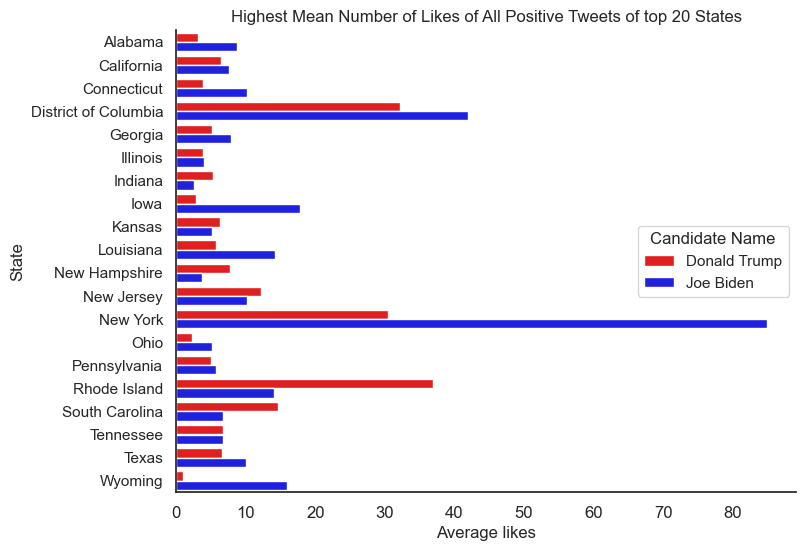

In [367]:
plot_follower = sns.barplot(
    data=pos_table_likes,
    x='likes',
    y='state',
    hue='Candidate Name',
    palette=my_palette  
)

# Set title and axis labels
plot_follower.set(
    title='Highest Mean Number of Likes of All Positive Tweets of top 20 States',
    xlabel='Average likes',
    ylabel='State'
)

# Removing spines
sns.despine()

# Move legend to center right
sns.move_legend(plot_follower, 'center right')

# Set figure size and style
plot_follower.figure.set_size_inches(8, 6)
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False}
)

##### The following code extracts out the tweets with the highest number of retweet count by state name for each candidate. We then compare both the candidates retweet counts wise based on the state with a bar plot.

In [368]:
top20_retweets = only_positive.groupby('state')['retweet_count'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_retweets = only_positive.groupby(['state', 'Candidate Name'])['retweet_count'].mean().reset_index()
pos_table_retweets = pos_table_retweets[pos_table_retweets['state'].isin(top20_retweets)]

##### The code outputs the highest average number of retweets for all positive tweets of the top 20 states by Candidates. We observe that NewYork and District of Columbia has the highest number of average retweet counts for Joe Biden's positive tweets. It is not a coincidence as we will see that Joe Biden infact did win in NewYork and the District of Columbia. Similarly, Trump won in South carolina where he had a higher average number of retweet counts on his positive tweets 

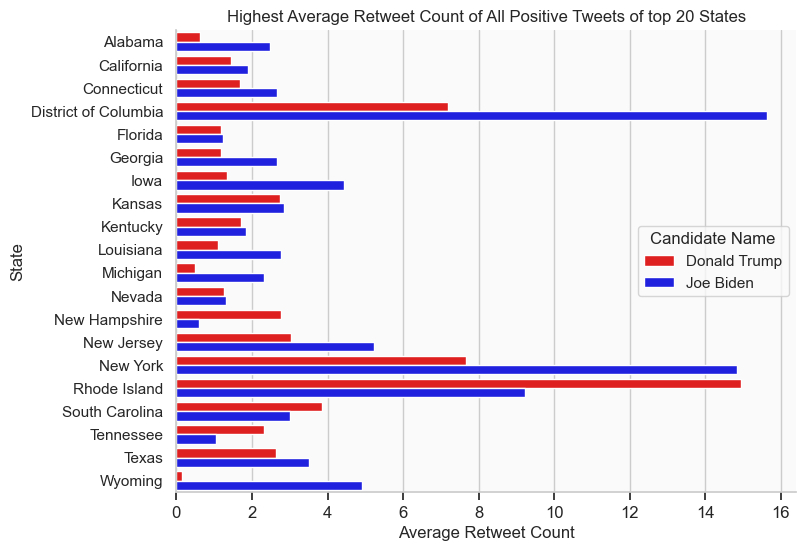

In [369]:
plot_follower = sns.barplot(
    data=pos_table_retweets,
    x='retweet_count',
    y='state',
    hue='Candidate Name',
    palette=my_palette  
)

# Set title and axis labels
plot_follower.set(
    title='Highest Average Retweet Count of All Positive Tweets of top 20 States',
    xlabel='Average Retweet Count',
    ylabel='State'
)

# Removing spines
sns.despine()

# Move legend to center right
sns.move_legend(plot_follower, 'center right')

# Set figure size and style
plot_follower.figure.set_size_inches(8, 6)
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False}
)

##### The following code extracts out the tweets with the highest number of user follower count by state name for each candidate. We then compare both the candidates retweet counts wise based on the state with a bar plot.

In [370]:
top20_follower = only_positive.groupby('state')['user_followers_count'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_follower = only_positive.groupby(['state', 'Candidate Name'])['user_followers_count'].mean().reset_index()
pos_table_follower = pos_table_follower[pos_table_follower['state'].isin(top20_follower)]

##### We plot the barplot and observe a similar trend particularly regarding NewYork and District of Columbia. However, we see that New Jersey has a lot of user followers with positive tweets yet it was Biden who won the election in New Jersey. Note how there is an average of 40000 twitter user followers for Biden positive tweets in District of Columbia.  

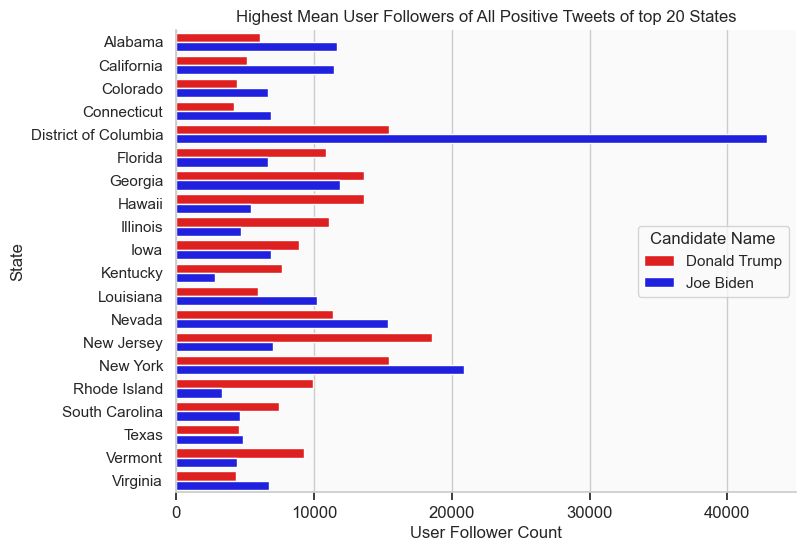

In [371]:
plot_follower = sns.barplot(
    data=pos_table_follower,
    x='user_followers_count',
    y='state',
    hue='Candidate Name',
    palette=my_palette  
)

# Set title and axis labels
plot_follower.set(
    title='Highest Mean User Followers of All Positive Tweets of top 20 States',
    xlabel='User Follower Count',
    ylabel='State'
)

# Removing spines
sns.despine()

# Move legend to center right
sns.move_legend(plot_follower, 'center right')

# Set figure size and style
plot_follower.figure.set_size_inches(8, 6)
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False}
)

#### Total Votes VS Average Likes by State
##### Notice how we observe a general positive corelation between average likes and total vote counts for most states.  Nevertheless, we can comfortably assert that there is a weak association between both the variables. There are some states which can be considered outliers and be removed. Moreover, if we look closely on the bottom left, there is a cluster which would indicate that both of them are indeed related to each other. The addition of the linear regression line complements the positive relation even more between the average likes and total votes. Note that all dots represent a specific state

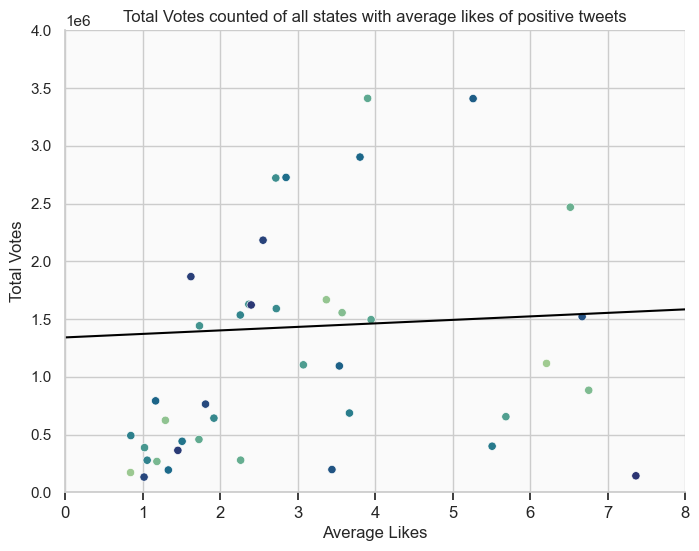

In [372]:
x = mean_pos_table['likes'].values.reshape(-1,1)
y = mean_pos_table['total_votes'].values.reshape(-1,1)
plot_avg_likes = sns.scatterplot(data = mean_pos_table,x = 'likes', y = 'total_votes', hue = 'state', legend = False, palette='crest')
plot_avg_likes.set(title = 'Total Votes counted of all states with average likes of positive tweets',xlabel= 'Average Likes', ylabel = 'Total Votes', xlim=(0, 8), ylim = (0, 4000000))
lr.fit(x,y)
x = np.linspace(0.0, 8.0).reshape(-1, 1)
y_pred = lr.predict(x)
plot_avg_likes.plot(x, y_pred, color = 'black')
sns.despine()
plot_avg_likes.figure.set_size_inches(8, 6)
sns.set_style(style = 'white', rc = {"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': True})

#### Total Votes vs Average Retweet Count
##### In this scatter plot we can observe a general positive corelation between average retweet counts and total vote counts for most states. Moreover, there is a weak association between both the variables meaning that some states do not follow the general trend strictly. So, there can be some states which can be considered outliers and be removed. Moreover, if we look closely on the bottom half of the plot, there is a cluster which would indicate that both variables are corelated to each other. The linear regression line also depicts the positive relation between the average retweet count and total votes. Note that all dots represent a specific state
 

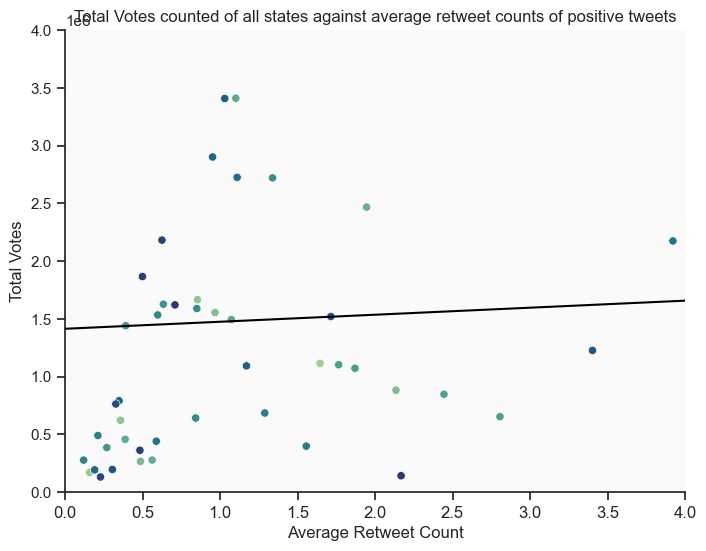

In [373]:
x = mean_pos_table['retweet_count'].values.reshape(-1,1)
y = mean_pos_table['total_votes'].values.reshape(-1,1)
plot_avg_retweet = sns.scatterplot(data = mean_pos_table,x = 'retweet_count', y = 'total_votes', hue = 'state', legend = False, palette='crest')
plot_avg_retweet.set(title = 'Total Votes counted of all states against average retweet counts of positive tweets', xlabel = 'Average Retweet Count', ylabel = 'Total Votes',xlim=(0, 4), ylim = (0, 4000000))
lr.fit(x,y)
x = np.linspace(0.0, 4.0).reshape(-1, 1)
y_pred = lr.predict(x)
plot_avg_retweet.plot(x, y_pred, color = 'black')
sns.despine()
plot_avg_retweet.figure.set_size_inches(8, 6)
sns.set_style(style = 'white', rc = {"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': True})

#### Total Votes vs Average User Follower
##### Through this plot, we can infer a direct corelation between average user follower count and total vote counts for most states(all dots represent a specific state). Moreover, there is a partially strong association between both the variables if we see the bottom half of the plot. However, some states do not follow the general trend and maybe considered outliers. The linear regression line clearly shows a positive relation between the average user follower count and total votes.

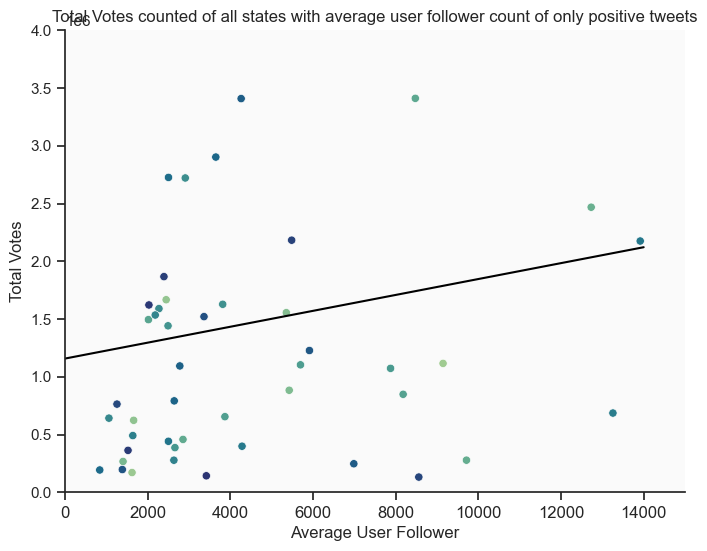

In [374]:
x = mean_pos_table['user_followers_count'].values.reshape(-1,1)
y = mean_pos_table['total_votes'].values.reshape(-1,1)
plot_avg_user = sns.scatterplot(data = mean_pos_table,x = 'user_followers_count', y = 'total_votes', hue = 'state', legend = False, palette='crest')
plot_avg_user.set(title = 'Total Votes counted of all states with average user follower count of only positive tweets', xlabel = 'Average User Follower', ylabel = 'Total Votes', xlim=(0, 15000), ylim = (0,4000000))
lr.fit(x,y)
x = np.linspace(0.0, 14000.0).reshape(-1, 1)
y_pred = lr.predict(x)
plot_avg_user.plot(x, y_pred, color = 'black')
sns.despine()
plot_avg_user.figure.set_size_inches(8, 6)
sns.set_style(style = 'white', rc = {"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': True})

# Project 2

## The Message

##### The project is based upon the question over how the public engagement on Twitter is quantified towards political parties to predict election results through Sentiment Analysis of the tweets present in our data sets. Continuing my previously used independent variables (average number of likes, user follower count and retweet count of the tweets) from Project 1, I will move forward to demonstrate over how those variables have the relationship with the total number of votes recieved by each candidate. 

##### The second project aims to distinguish the relationship between the average retweet counts, likes and follower counts with the votes recieved by each candidate. Althought we did observed the positive relationships between the variables with only the positive tweets previously, we will now see the difference between how strong association and relationship between the variables are for each candidate for the tweets of a candidate regardless of the sentiment. In particular, the idea is if the relationship between variables are stronger for a specific candidate, it would reflect on the public engagement in a state and eventually the final results of the election. The concept is slightly counter-intuitive as we will see in the upcoming figures. Since, the data set we have has more significantly more tweets for Biden than Trump.

##### Moreover the maps aim to show how we can observe the distribution of the positive and negative emotions in each state for each candidate. The maps can become a good predictor over which candidate won in a state which depends on whether that state corresponds to stronger or weaker sentiment (positive or negative in our case). We observe in our study that not only a high positivity score but a low negativity score can also become a good predictor over who wins in some states specially if they are the battle ground states demonstrating high competition among the candidates. 

##### The following code creates a data frame that contains the average number of likes of the positive and negative sentiment tweets of Trump and Biden of each state. The data frame categorized the tweets with sentiment of each candidate and the calculated the average number of likes for each state. This data frame will then be used to create the individual scatter plots for Biden and Trump. 

In [375]:
only_negative = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Negative']
pos_neg_only = trump_biden_data.loc[trump_biden_data['Sentiment'] != 'Neutral']

all_state_likes = pos_neg_only.groupby(['state'])['likes'].mean().sort_values(ascending = False).index.tolist()
pos_neg_likes = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['likes'].mean().reset_index()
pos_neg_likes = pos_neg_likes[pos_neg_likes['state'].isin(all_state_likes)]

pos_neg_vote_likes = pd.merge(pos_neg_only, tvbs, on = ['state', 'Candidate Name'])
pos_neg_vote_likes = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['likes'].mean().reset_index()
pos_neg_vote_likes = pos_neg_vote_likes[pos_neg_vote_likes['state'].isin(all_state_likes)]

pos_neg_likes_sent = pd.merge(tvbs,pos_neg_vote_likes, on = ['state','Candidate Name'])

##### The following code removes the outlier states which were too high and made the relationship between the variables skewed. Moreover we made two separate data frames for our candidates Trumo and Biden which will be used to plot oour graphs. The plots shows the relationship between the average number of likes and vote count. Each dot in the scatter plots represent a state in the United States. 

##### Note here we observe that in the Trump graph, average likes and total votes has a stronger relationship which can be seen through the regression line when compared to the Biden graph which has a weaker association. The regression line explains a slighlty counter-intuitve idea. Since, Trump tweets in most states recieved average likes under 10, there is a cluster in the lower left corner for him. There are quite a few states that had a high average number of likes for Biden Tweets which made the regression line more flatter for him. This is clearly because Biden's tweets has more enagegement on his tweets. Thus in our model, the weaker the association the more the engagement!

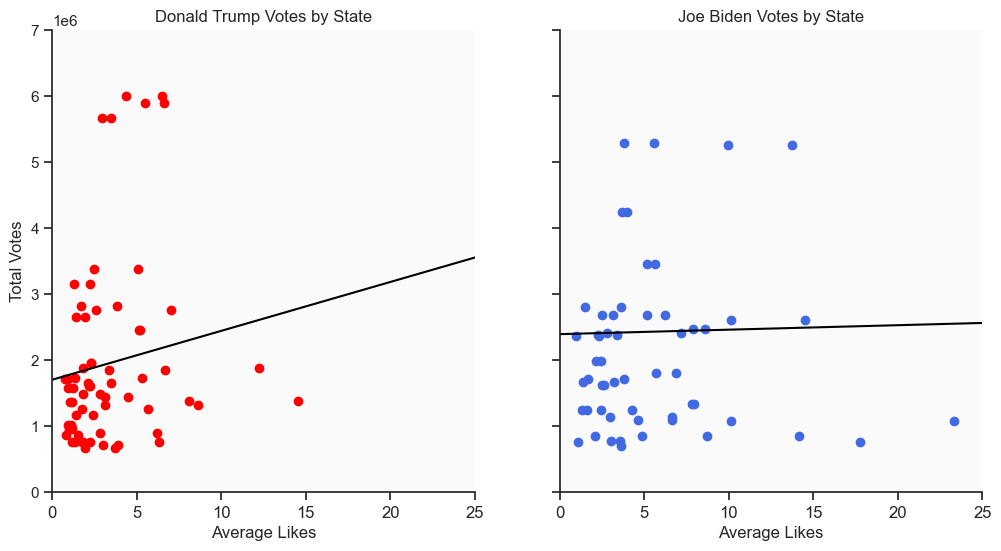

In [376]:
import numpy as np
from scipy.stats import linregress

trump_likes_only = pos_neg_likes_sent[pos_neg_likes_sent['Candidate Name'] == 'Donald Trump']
trump_likes_only = trump_likes_only.loc[trump_likes_only['likes'] < 40]
trump_likes_only = trump_likes_only.loc[trump_likes_only['total_votes'] > 650000]
biden_likes_only = pos_neg_likes_sent[pos_neg_likes_sent['Candidate Name'] == 'Joe Biden']
biden_likes_only = biden_likes_only.loc[biden_likes_only['likes'] < 40]
biden_likes_only = biden_likes_only.loc[biden_likes_only['total_votes'] > 650000]

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# plot the positive sentiment scatter plot in the first subplot
axs[0].scatter(trump_likes_only['likes'], trump_likes_only['total_votes'], color='red')
axs[0].set(title = 'Donald Trump Votes by State', xlabel = 'Average Likes', ylabel = 'Total Votes')
axs[0].set(xlim = (0,25), ylim = (0,7000000))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# calculate and plot the regression line for positive sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(trump_likes_only['likes'], trump_likes_only['total_votes'])
x = np.array([0, 25])
y = intercept + slope * x
axs[0].plot(x, y, color='black')

# plot the negative sentiment scatter plot in the second subplot
axs[1].scatter(biden_likes_only['likes'], biden_likes_only['total_votes'], color='royalblue')
axs[1].set(title = 'Joe Biden Votes by State', xlabel = 'Average Likes')
axs[1].set(xlim = (0,25))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# calculate and plot the regression line for negative sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(biden_likes_only['likes'], biden_likes_only['total_votes'])
x = np.array([0, 25])
y = intercept + slope * x
axs[1].plot(x, y, color='black')

plt.show()

##### The following code creates a data frame that contains the average number of retweets of the positive and negative sentiment tweets of Trump and Biden of each state. The data frame categorized the tweets with sentiment of each candidate and the calculated the average number of retweets for each state. This data frame will then be used to create the individual scatter plots for Biden and Trump. 

In [377]:
all_state_retweet = pos_neg_only.groupby(['state'])['retweet_count'].mean().sort_values(ascending = False).index.tolist()
pos_neg_retweet = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['retweet_count'].mean().reset_index()
pos_neg_retweet = pos_neg_retweet[pos_neg_retweet['state'].isin(all_state_retweet)]

In [378]:
pos_neg_vote_retweet = pd.merge(pos_neg_only, tvbs, on = ['state', 'Candidate Name'])
pos_neg_vote_retweet = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['retweet_count'].mean().reset_index()
pos_neg_vote_retweet = pos_neg_vote_retweet[pos_neg_vote_retweet['state'].isin(all_state_retweet)]

In [379]:
pos_neg_retweet_sent = pd.merge(tvbs,pos_neg_vote_retweet, on = ['state','Candidate Name'])

##### The following code removes the outlier states which contained high average retweet counts that made the relationship between the variables skewed. Moreover we made two separate data frames for our candidates Trumo and Biden which will be used to plot oour graphs. The plots shows the relationship between the average number of retweets and vote count in each state. Each dot in the scatter plots represent a state in the United States. 

##### Note here we observe that in the Trump graph, average retweet and total votes has a stronger association which can be observed by the regression line as compared to the Biden graph which has a weaker relationship. The regression line explains a slighlty counter-intuitve idea. Since, Trump tweets in most states recieved average retweets under 4, there is a cluster in the lower left corner for him. There are quite a few states that had a high average number of retweets of which many are much higher than 4 for Biden Tweets which made the regression line more flatter for him. This is clearly because Biden's tweets has more enagegement on his tweets through higher number of retweets per tweet. This is another example of how a weaker association corelates higher engagement. 

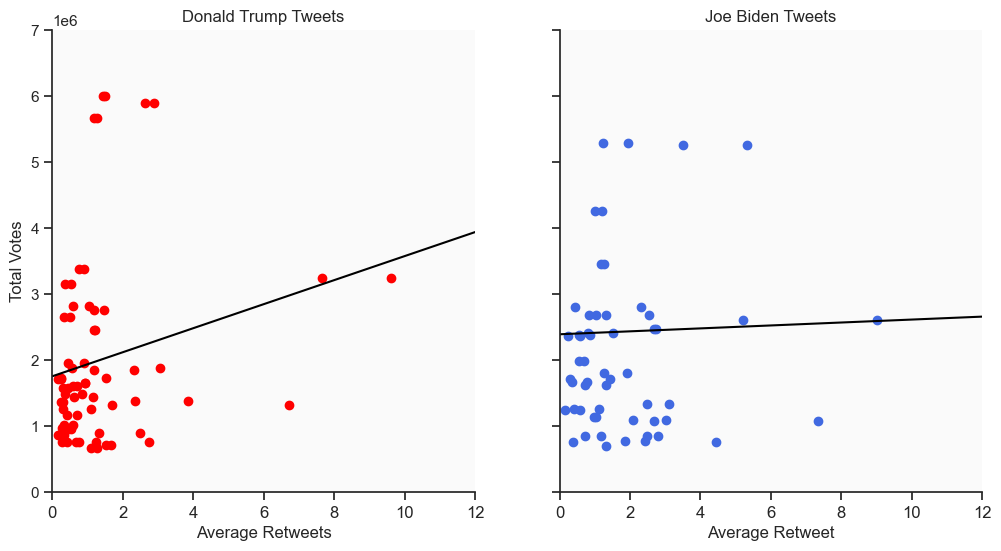

In [380]:
import numpy as np
from scipy.stats import linregress

trump_retweet_only = pos_neg_retweet_sent[pos_neg_retweet_sent['Candidate Name'] == 'Donald Trump']
trump_retweet_only = trump_retweet_only.loc[trump_retweet_only['retweet_count'] < 10]
trump_retweet_only = trump_retweet_only.loc[trump_retweet_only['total_votes'] > 650000]
biden_retweet_only = pos_neg_retweet_sent[pos_neg_retweet_sent['Candidate Name'] == 'Joe Biden']
biden_retweet_only = biden_retweet_only.loc[biden_retweet_only['retweet_count'] < 10]
biden_retweet_only = biden_retweet_only.loc[biden_retweet_only['total_votes'] > 650000]

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# plot the positive sentiment scatter plot in the first subplot
axs[0].scatter(trump_retweet_only['retweet_count'], trump_retweet_only['total_votes'], color='red')
axs[0].set(title = 'Donald Trump Tweets', xlabel = 'Average Retweets', ylabel = 'Total Votes')
axs[0].set(xlim = (0,12), ylim = (0,7000000))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# calculate and plot the regression line for positive sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(trump_retweet_only['retweet_count'], trump_retweet_only['total_votes'])
x = np.array([0, 16])
y = intercept + slope * x
axs[0].plot(x, y, color='black')

# plot the negative sentiment scatter plot in the second subplot
axs[1].scatter(biden_retweet_only['retweet_count'], biden_retweet_only['total_votes'], color='royalblue')
axs[1].set(title = 'Joe Biden Tweets', xlabel = 'Average Retweet')
axs[1].set(xlim = (0,12))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# calculate and plot the regression line for negative sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(biden_retweet_only['retweet_count'], biden_retweet_only['total_votes'])
x = np.array([0, 16])
y = intercept + slope * x
axs[1].plot(x, y, color='black')

plt.show()

##### The following code creates a data frame that contains the user followers that tweeted about Biden and Trump. The data frame is categorized with the sentiment by each state for each candidate. We then calculated the average number of user follower for each state. This data frame will then be used to create the individual scatter plots for Biden and Trump.

In [381]:
all_state_follower = pos_neg_only.groupby(['state'])['user_followers_count'].mean().sort_values(ascending = False).index.tolist()
pos_neg_follower = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['user_followers_count'].mean().reset_index()
pos_neg_follower = pos_neg_follower[pos_neg_follower['state'].isin(all_state_follower)]

In [382]:
pos_neg_vote_follower = pd.merge(pos_neg_only, tvbs, on = ['state', 'Candidate Name'])
pos_neg_vote_follower = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['user_followers_count'].mean().reset_index()
pos_neg_vote_follower = pos_neg_vote_follower[pos_neg_vote_follower['state'].isin(all_state_follower)]

In [383]:
pos_neg_follower_sent = pd.merge(tvbs,pos_neg_vote_follower, on = ['state','Candidate Name'])

##### The following code removes the outlier states which contained high average user follower counts that made the relationship between the variables skewed. Moreover we made two separate data frames for our candidates Trump and Biden which will be used to plot our graphs. The plots shows the relationship between the average number of user followers and vote count in each state. Each dot in the scatter plots represent a specific state in the United States. 

##### Just like in other graphs, we observe here too that in the Trump graph, average user followers and total votes has a stronger association which can be observed by the regression line as compared to the Biden graph which has a weaker relationship. This is another example of how the weaker association asserts more public engagement. Simiarly, Trump has a more dense cluster in the lower left corner of the first plot thna compared to Biden. This is because Biden has tweets that were tweeted by users with higher follower counts on average in more states than Trump. Thus, Biden's regression line also depicts weaker asscociation between the total votes and user follower count. This is another example of higher public engagement with weaker association. 

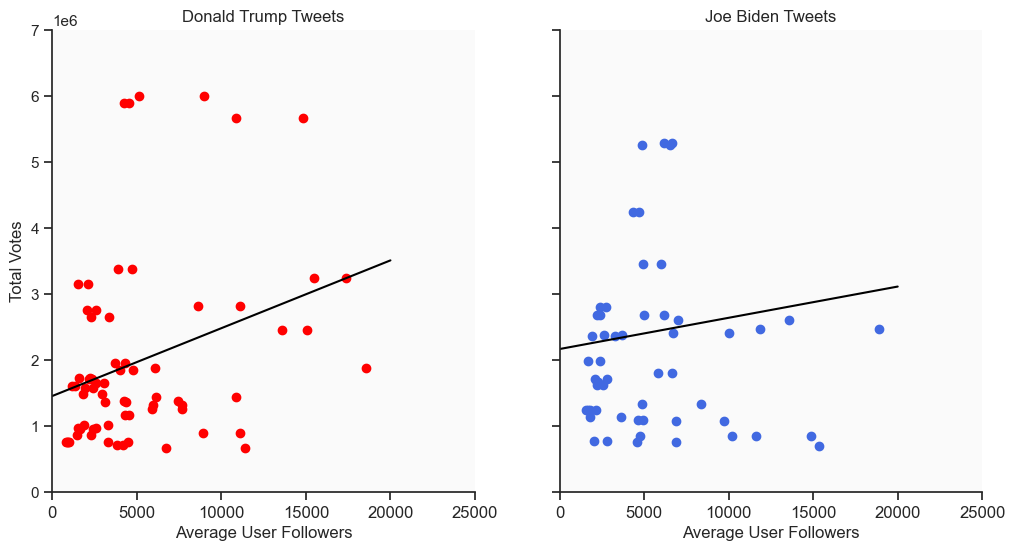

In [384]:
import numpy as np
from scipy.stats import linregress

trump_follower_only = pos_neg_follower_sent[pos_neg_follower_sent['Candidate Name'] == 'Donald Trump']
trump_follower_only = trump_follower_only.loc[trump_follower_only['user_followers_count'] < 20000]
trump_follower_only = trump_follower_only.loc[trump_follower_only['total_votes'] > 650000]
biden_follower_only = pos_neg_follower_sent[pos_neg_follower_sent['Candidate Name'] == 'Joe Biden']
biden_follower_only = biden_follower_only.loc[biden_follower_only['user_followers_count'] < 20000]
biden_follower_only = biden_follower_only.loc[biden_follower_only['total_votes'] > 650000]

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# plot the positive sentiment scatter plot in the first subplot
axs[0].scatter(trump_follower_only['user_followers_count'], trump_follower_only['total_votes'], color='red')
axs[0].set(title = 'Donald Trump Tweets', xlabel = 'Average User Followers', ylabel = 'Total Votes')
axs[0].set(xlim = (0,25000), ylim = (0,7000000))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# calculate and plot the regression line for positive sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(trump_follower_only['user_followers_count'], trump_follower_only['total_votes'])
x = np.array([0, 20000])
y = intercept + slope * x
axs[0].plot(x, y, color='black')

# plot the negative sentiment scatter plot in the second subplot
axs[1].scatter(biden_follower_only['user_followers_count'], biden_follower_only['total_votes'], color='royalblue')
axs[1].set(title = 'Joe Biden Tweets', xlabel = 'Average User Followers')
axs[1].set(xlim = (0,25000))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# calculate and plot the regression line for negative sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(biden_follower_only['user_followers_count'], biden_follower_only['total_votes'])
x = np.array([0, 20000])
y = intercept + slope * x
axs[1].plot(x, y, color='black')

plt.show()

## Maps and Interpretations

##### The aim of the research is to quanitify public engagement on Twitter and predict election results. The maps essentially use the polarity scores as an independent variable and see how the mean positive and negative scores get distributed throughout all the states in the US. 
##### Since all maps are interactive as they were coded with plotly express this is the google drive link to the html of this file, https://drive.google.com/drive/folders/1rpYbIMpCCq9Wol1qGlANHOiPGSJg9uZ8?usp=sharing

##### The maps in this research below aims to clearly indicate how a high positivity score for each candidate in a state can predict if they would win in the particular state or not. Moreover, we should not only restrict ourselves with the positive score for each candidate, we also account for the negative tweets and their negativity scores for each candidate. The negativity scores can also indicate where a candidate would win or lose depending on how strong the negative sentiment they recieved in a state on Twitter. For example, a strong negative sentiment would indicate that the candidate should have lost in the said state. Note that my independent variables in the maps are the positive and negative scores!

##### We convert the polarity score column into a dictionary so we can further separate the tweets between positive and negative tweets

In [385]:
only_positive['polarity_score'].convert_dtypes(dict)
only_negative['polarity_score'].convert_dtypes(dict)

5         {'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compou...
19        {'neg': 0.504, 'neu': 0.496, 'pos': 0.0, 'comp...
25        {'neg': 0.127, 'neu': 0.873, 'pos': 0.0, 'comp...
29        {'neg': 0.206, 'neu': 0.712, 'pos': 0.082, 'co...
35        {'neg': 0.643, 'neu': 0.175, 'pos': 0.181, 'co...
                                ...                        
352502    {'neg': 0.661, 'neu': 0.339, 'pos': 0.0, 'comp...
352522    {'neg': 0.385, 'neu': 0.33, 'pos': 0.286, 'com...
352541    {'neg': 0.102, 'neu': 0.844, 'pos': 0.054, 'co...
352568    {'neg': 0.173, 'neu': 0.737, 'pos': 0.09, 'com...
352581    {'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'comp...
Name: polarity_score, Length: 59674, dtype: object

##### The following code creates a data frame that contains the only positive tweets that was created in Project 1. We now add another column in this new data frame which contains the positivity score (referred to as polarity score before) for each tweet. Note that we already calculated these scores from our Sentiment Analyzer previously and we are no extracting them out for mapping. Moreover, we keep all the observations from the United States only. Remember that this data set still contains both the Candidate positive tweets which will soon categorize.

In [386]:
state_op = only_positive[only_positive['country'] == 'United States of America'].dropna(subset=['state_code'])
state_op['positive'] = state_op.polarity_score.apply(lambda x: x.get('compound'))

##### We do a similar procedure for the negativity scores. We use the data frame that contains only the negative tweets of both the candidates and extract out the negative score for each tweet. We make a new column and assign the negativity score to each tweet which was calculated by our sentiment analyzer.

In [387]:
state_on = only_negative[only_negative['country'] == 'United States of America'].dropna(subset = ['state_code'])
state_on['negative'] = state_on.polarity_score.apply(lambda x: x.get('compound'))

##### This is the most important part of the project. We now separate our negative and positive tweets by each candidate. We want to observe the mean distribution scores for the positive and negative sentiments separately for Biden and Trump throughout all the states.  

In [388]:
state_opt = state_op.loc[state_op['Candidate Name'] == 'Donald Trump']
state_opt_1 = state_opt.groupby(['state', 'state_code'])['positive'].mean().reset_index()

state_opb = state_op.loc[state_op['Candidate Name'] == 'Joe Biden']
state_opb_1 = state_opb.groupby(['state', 'state_code'])['positive'].mean().reset_index()

In [389]:
state_ont = state_on.loc[state_on['Candidate Name'] == 'Donald Trump']
state_ont_1 = state_ont.groupby(['state', 'state_code'])['negative'].mean().reset_index()

state_onb = state_on.loc[state_on['Candidate Name'] == 'Joe Biden']
state_onb_1 = state_onb.groupby(['state', 'state_code'])['negative'].mean().reset_index()

##### The following code outputs the mean positivity score distribution for all the positive tweets of Donald Trump in the states. We observe that the higher the positivity score, the darker the region is (dark red). In Trump’s case, we see Texas, Oklahoma, Kansas, North Dakota and Alaska has a high positivity score for Donald Trump (positivity score ranging between 0.6 and 0.7). This should clearly indicate that he should win in those states. In fact, he did win all the aforementioned states! There are a few outlier states which are contradictory to our results for example the state of Nevada, Wisconsin, Michigan and Virginia where Biden won, but Trump did receive positive sentiment tweets from these states. Note that the outlier states were battle ground states meaning both the candidates had an equal chance of winning in that state and the competition was not one-sided. Similarly, as we would expect a low positivity score for Trump would essentially indicate that he should lose in those states for example we see Georgia, Washington and New York with low positive scores where he indeed lost. (Use the interactive feature to look for states!)

In [390]:
fig = px.choropleth(state_opt_1,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='positive',
                    color_continuous_scale=('Reds'),
                    range_color=(0.4,0.55),
                    color_continuous_midpoint=0,
                    title = 'Positivity Scores for Donald Trump Tweets'
                    )

fig.add_scattergeo(
    locations=state_opt_1['state_code'],
    locationmode="USA-states", 
    text=state_opt_1['state_code'],
    mode='text'
)
fig.show()

##### The following code outputs the mean positivity score distribution for all the positive tweets of Joe Biden in the states. We observe that the higher the positivity score, the darker the region is (dark blue). In Biden’s case, we see Washington, Colorado, Wisconsin and New Jersey has a high positivity score for Joe Biden  (positivity score ranging between 0.6 and 0.7). Biden did win in all the aforementioned states. There are a few outlier states which are contradictory to our results for example the state of Iowa and Wyoming where Trump won, but Biden did receive high positive sentiment tweets from these states. Similarly, as we would expect a low positivity score for Biden would essentially indicate that he should lose in those states for example we see Florida, Utah and Ohio with low positive scores where he indeed lost. There are a few contradictions as well like in Nevada and Virginia where Biden received very few positive sentiments, yet he won there. This is consistent with our contradiction from the previous map too! (Use the interactive feature to look for states!)

In [391]:
state_opb_1['state_code'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [392]:
fig = px.choropleth(state_opb_1,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='positive',
                    color_continuous_scale=('blues'),
                    range_color=(0.4,0.53),
                    color_continuous_midpoint=0,
                    title = 'Positivity Scores for Joe Biden Tweets'
                    )
fig.add_scattergeo(
    locations=state_opb_1['state_code'],
    locationmode="USA-states", 
    text=state_opb_1['state_code'],
    mode='text'
)
fig.show()

##### We mentioned that the negative sentiment is also a good indicator for prediction. A state where a candidate would receive high negative sentiment scores, we would expect them to lose there and vice versa. 

##### The map below shows the distribution of the mean negative score for all negative tweets of Donald Trump by state. The negativity scale can be interpreted as the more the negative the lighter the region would be, light red in this case (i.e. a score of -0.7 would be considered strong negative sentiment). The states which received low negative sentiment by Trump were Kansas, Kentucky and West Virginia which is consistent with the election results since Trump won in all the aforementioned states. There are a few contradictions like Texas and Mississippi where Trump received strong negative sentiment tweets yet he won in the said states. Nevertheless, a low negative score can indicate whether the candidate could win there or not. 

In [393]:
fig = px.choropleth(state_ont_1,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='negative',
                    color_continuous_scale=('Reds'),
                    range_color=(-0.59,-0.44),
                    color_continuous_midpoint=0,
                    title = 'Negativity Scores for Donald Trump Tweets'
                    )

fig.add_scattergeo(
    locations=state_ont_1['state_code'],
    locationmode="USA-states", 
    text=state_ont_1['state_code'],
    mode='text'
)
fig.show()

##### The following code outputs the map of the mean distribution of the negativity scores for all the negative tweets received by Biden by state. Biden received strong negative sentiment tweets in Texas, Idaho, Nebraska and Wyoming where we would expect him to lose and he did lose indeed in the said states. Similarly, he received very low negative sentiment scores in Washington and Oregon which explains why he won there. There are a few contradictions like Kansas where Biden received low negative sentiments yet, he lost. This is consistent with our previous map where Trump received high positivity scores in Kansas in particular. Thus, once we compare the graphs accordingly, we can see the relative scores between each candidate has a major impact on who would win in that state. 

In [394]:
fig = px.choropleth(state_onb_1,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='negative',
                    color_continuous_scale=('blues'),
                    range_color=(-0.60,-0.45),
                    color_continuous_midpoint=0,
                    title = 'Negativity Scores for Donald Trump Tweets'
                    )

fig.add_scattergeo(
    locations=state_onb_1['state_code'],
    locationmode="USA-states", 
    text=state_onb_1['state_code'],
    mode='text'
)
fig.show()

##### Nevertheless, if a candidate which has strong negative sentiment and weak positive sentiment in a state, we would expect them to eventually lose. Similarly, if someone has weak negative and strong positive sentiment in a state, we would expect them to win. In the future relative scores between positive and negative scores for a candidate can play an intriguing role in calculating and predicting how each candidate did there. 

## Merging with the 2020 Election Results Data Set

##### The following code creates a new data frame with the state name and the candidate who won in that particular state. The data frame was created by using the president county data from the election results data set. An interactive map will show which candidate won in which states!

In [395]:
first_two_rows_by_state = tvbs.groupby('state').head()

# Loop over the unique states in the first two rows and create a new data frame for each state
def vic(df):
    state_dfs = []
    for state in first_two_rows_by_state['state'].unique():
        # Get the vote counts for the two candidates in the current state
        state_rows = first_two_rows_by_state[first_two_rows_by_state['state'] == state]
        candidate_1_votes = state_rows.iloc[0,2]
        candidate_2_votes = state_rows.iloc[1,2]
        
        # Determine which candidate won the state
        if (candidate_1_votes > candidate_2_votes).all():
            winner = 'Donald Trump'
        else:
            winner = 'Joe Biden'
        
        # Create a new data frame for the current state with a single row containing the winner's name
        state_df = pd.DataFrame({'State': [state], 'Winner': [winner]})
        state_dfs.append(state_df)
        
    # Concatenate the state data frames into a single data frame
    result_df = pd.concat(state_dfs, ignore_index=True)
    return result_df
winner = vic(tvbs)

In [396]:
# renaming columns for data merging
winner.rename(columns = {'State' : 'state'}, inplace = True)

In [397]:
# Merging the winner data set with a data set that contains the state names
winner = pd.merge(winner, only_positive, on = ['state'])
winner_1 = winner.groupby(['state', 'state_code', 'Winner'])['retweet_count'].count().reset_index()

##### The following code makes a map showing which candidate won in each state in the United States. This gives us a way to comare our results from our previous map interpretations and results.

In [398]:
import plotly.express as px
color_map = {'Donald Trump': 'red', 'Joe Biden': 'royalblue'}
fig = px.choropleth(winner_1, 
                    locationmode='USA-states',
                    locations='state_code',
                    color='Winner',
                    scope='usa',
                    color_discrete_map=color_map, 
                    title = '2020 Election Results by State')

fig.add_scattergeo(
    locations=winner_1['state_code'],
    locationmode="USA-states", 
    text=winner_1['state_code'],
    mode='text'
)
fig.show()

# Project 3

## Potential Data to Scrape
##### Alongside the twitter data set that reflects the tweets of the two primary candidates, Donald Trump and Joe Biden, there is a possibility to explore a new relation between the proportion of people who tweeted about the candidate on Twitter and what was the proportion who actually voted on the election day. To analyze this relationship we would require the population data of each state. For that purpose, we need a data set that contains the population size of each state. Although we had millions of tweets in our datasets, there was a void and a question of how much those tweets was representative of votes received by each candidate by the people. 
##### An analysis with the population parameter would put further emphasis on how data from Twitter could be impactful and act as a reliable source to predict the presidential election outcomes. If only, we could observe a similar ratio of the people who tweeted in a state for a candidate also voted for their favored candidate, we could conclude with concrete evidence that the twitter data indeed is reliable for predicting election results. The main idea of these calculations would be to demonstrate the public engagement on twitter and compare it to the engagement people show by moving forward in their ideas by voting their preferred candidate on the election day.
##### Thus, scraping of the population of each state was required. Luckily, we had the 2020 population census available on Wikipedia and a nice table was available for each state. The table was the Population and population change in the United States by state of the year 2020. The table can be viewed on the following website; https://en.wikipedia.org/wiki/2020_United_States_census#State_rankings. We merge the population data set with the total votes data set and calculate the proportion of total votes received by each candidate compared to the population size of that state. Furthermore, this would also help us visualize which candidate had a higher ratio of support in each state. 


## Potential Challenges 
##### The population census is a very complex process for which the data takes months to gather until the final numbers are published by the United States Census Bureau. Moreover, population census is very costly and there are numerous external factors including corruption and political agendas that affect the population census numbers drastically. After some further research, I learned about the limitations of the 2020 Population census, which showed that it undercounted many of the same population groups that were historically undercounted and overcounted some other groups. It was revealed that the 2020 census undercounted the African American Population, the Alaska Native population and the Latino population. Similarly, the census also overcounted the White and Asian population. 
##### Moreover, it is vital to note that there is a gap between the population data I have and the data I would need. The minimum age to vote in the United States is 18 or above and so, I would essentially need the population data of the people ages over 18. Unfortunately, the data we have from Wikipedia that could be retrieved through scraping contains the total population regardless of the age. This will eventually affect our results statistically and can potentially hinder to answer our research question with solid evidence. Moreover, the minimum age to make a twitter account is 13 which also makes it more challenging to compare the two proportions. Similarly, the census was released in April of 2020 while the election took place in November of 2020 which widened the gap due to time. These challenges are majorly faced due to the nature of the data and its collection in itself.
##### The Wikipedia table was scraped through the HTML based web scraping method. Just to make sure that the table contained the correct values, I compared the population values of each state by another website that was the US Department of Agriculture of Economic Research for accurate numbers. To be more precise in the research, we would need to scrape the data of population of different ages throughout each state ourselves for the future. This would give us detailed numbers and the timeframe in which they changed. 


## Scraping Data from a Website
##### The website data provided in the course for the Election 2020 results was the population data of New York for each zip code but I used the data which I scraped from Wikipedia as mentioned before.

##### We first import the neccessary python libraries like BeautifulSoap and Requests. BeautofulSoup is a widely used framework that uses scraping using python. Similarly, Requests, is a python module to send requests like HTTP. It is an easy library to use and we can pass parameters including URL's etc. Moreover, basic knowledge of HTML is also required to understand web scraping done below

In [399]:
import requests
from bs4 import BeautifulSoup

##### We first assign the link or the URL of the website from which the data has to be scraped from. After inspecting the element of the Wikipedia page, I saw that my table was stored in the <table> tag in HTML. I assigned my table class from the inspect element page to a new variable as well. We finally send a GET request to the Wikipedia URL. Note that we need to check the status code since, to ensure that we are scraping the data legally. The reponse 200 means that it was a successful response and so, it is safe to move ahead with the scraping process!

In [400]:
wikiurl = 'https://en.wikipedia.org/wiki/2020_United_States_census#State_rankings'
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(wikiurl)
response.status_code

200

##### We now create a BeautifulSoup object and using find() method extract the relevant information, which in our case is the <table> tag. Since there can be many tables in a Wikipedia page, we also specify the class and the id attribute of the <table> tag.

In [401]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
population_table = soup.find('table', {'class' : "wikitable"})

##### We now read the HTML table into a list of dataframe object using read_html() which returns a list. We then convert the list into a DataFrame. 

In [402]:
population_2020 = pd.read_html(str(population_table))
population_2020 = pd.DataFrame(population_2020[0])

##### After viewing the table, we clean the table and keep all the information which we need. We first sorted the states of the table in ascending alphabetical order. Then we drop the columns which are not needed for our analysis. Moreover, we rename the columns with meaningful names. We also removed the observation of USA which had the total population

In [403]:
population_2020 = population_2020.sort_values('State', ascending = True)
population_2020 = population_2020.reset_index(drop = True)
population_2020 = population_2020.drop(columns = ['Rank', 'Population as of2010 census[80]', 'Change', 'Percentchange'])
population_2020 = population_2020.rename(columns = {'Population as of2020 census[79]': 'Population 2020 census'})
population_2020_noUS = population_2020[population_2020['State'] != 'United States']
population_2020_noUS = population_2020_noUS.rename(columns = {'State' : 'state'})

##### We can see by the barplot below that the state with the highest population is California followed by Texas, Florida and New York.  

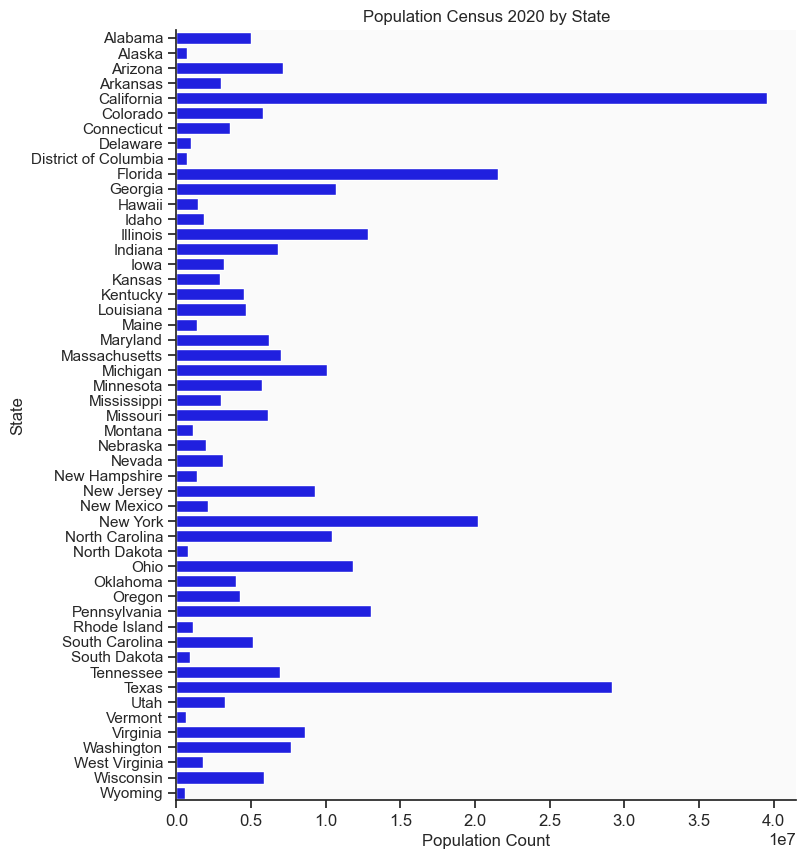

In [404]:
population_plot = sns.barplot(data = population_2020_noUS, x = 'Population 2020 census', y = 'state', color = 'blue')
sns.despine()
population_plot.figure.set_size_inches(8, 10)
population_plot.set(title = 'Population Census 2020 by State', xlabel = 'Population Count', ylabel = 'State')
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False})


##### The following code now merge the population data set and the previous data set of total votes by state data frame from the previous projects. We merge the data set by state name to compare the votes/population proportion. The data frame contains 102 entries for 51 states. Since the merging was done based on state, we have each vote counts for Trump and Biden separately for each state. 

In [405]:
votes_pop = pd.merge(tvbs, population_2020_noUS, on = 'state')

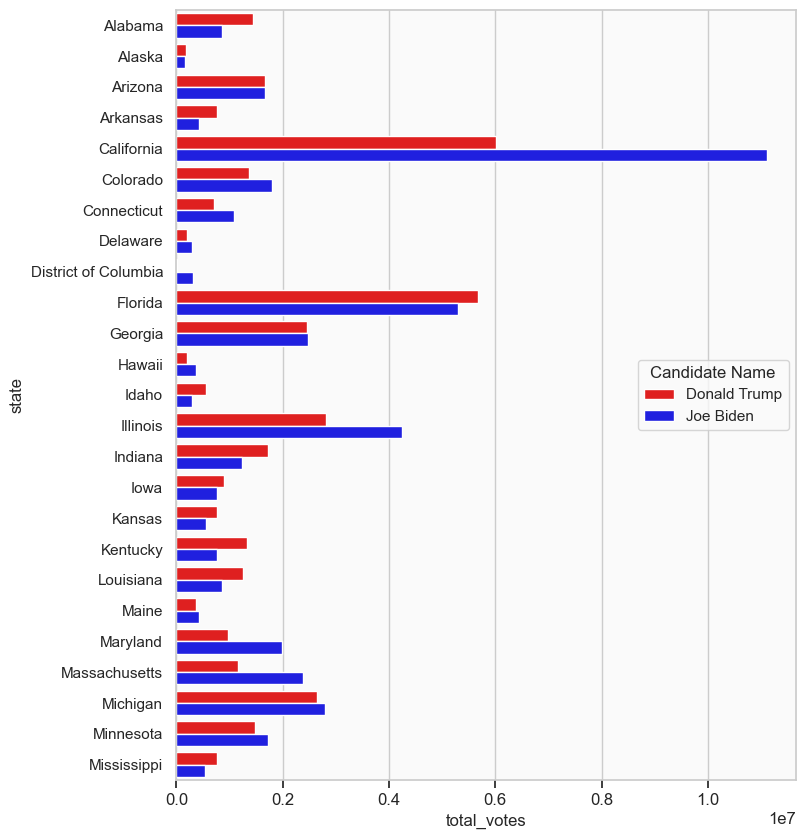

In [406]:
vote_count_plot = sns.barplot(data = votes_pop.head(50), x = 'total_votes', y = 'state', hue = 'Candidate Name', palette = my_palette)
vote_count_plot.figure.set_size_inches(8, 10)
sns.move_legend(vote_count_plot, 'center right')

##### The following code makes a data frame that only contains the state name na dit's code. I made this data frame for convenience to merge it with the data frames made later for mapping purposes. 

In [407]:
state_code = trump_biden_data.drop(columns = ['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent',
       'collected_at', 'Candidate Name', 'clean', 'clean', 'polarity_score', 'Sentiment'])
state_code = state_code.drop_duplicates()

##### The following code is the most important step of our project since it calculates the proportion of votes/population by state for each candidate and puts those value sinto a new column. We then create two separate datframes for each candidate for further visualizations and analysis!

In [408]:
votes_pop = pd.merge(state_code, votes_pop, on = 'state')
votes_pop['Votes_Population_Proportion'] = votes_pop['total_votes'] / votes_pop['Population 2020 census']
votes_pop = votes_pop.sort_values('state')
# this data set contains the proportion of total votes/population of each state
votes_pop_trump = votes_pop[votes_pop['Candidate Name'] == 'Donald Trump'] # only trump proportions
votes_pop_biden = votes_pop[votes_pop['Candidate Name'] == 'Joe Biden'] # only biden proportions 

##### The table below gives us a lot of the reasons why Biden won in the 2020 election. The mean proportion of Biden is greater tha Trump which indicates that Biden recieved more votes for each person in a state. Simialrly, The standard deviation of Trump is much higher compared to Biden's which means that Trump only got high number of votes in a few states while Biden had a higher proprotion of votes with respect to population in a lot of states. The maximum proportion of Biden is also higher than Trump and the minimum proportion of Trum is significantly lower for Trump too.

In [409]:
votes_pop.groupby('Candidate Name')['Votes_Population_Proportion'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,51.0,0.239557,0.055079,0.026954,0.20420,0.258043,0.270110,0.335544
Joe Biden,51.0,0.240775,0.070610,0.127266,0.18263,0.236887,0.290132,0.460192


##### The following histograms visualizes the proportions of each Candidate side-by-side. The histogram reaffirms the idea that Trump recieved a similar proportion in a lot of states while Biden received a varied proportion in the states. Since, Biden recieved a higher proportion (more than 0.3) in a lot of states, he therefore had an advantage of higher number of votes ending up winning the elections. It is important to realize through these graphs that more than half of the population of the USA do not vote in the elections. Ofcourse the population contains the people below 18 years of age, it still is a very low proportion of people who voted in general in the states. 

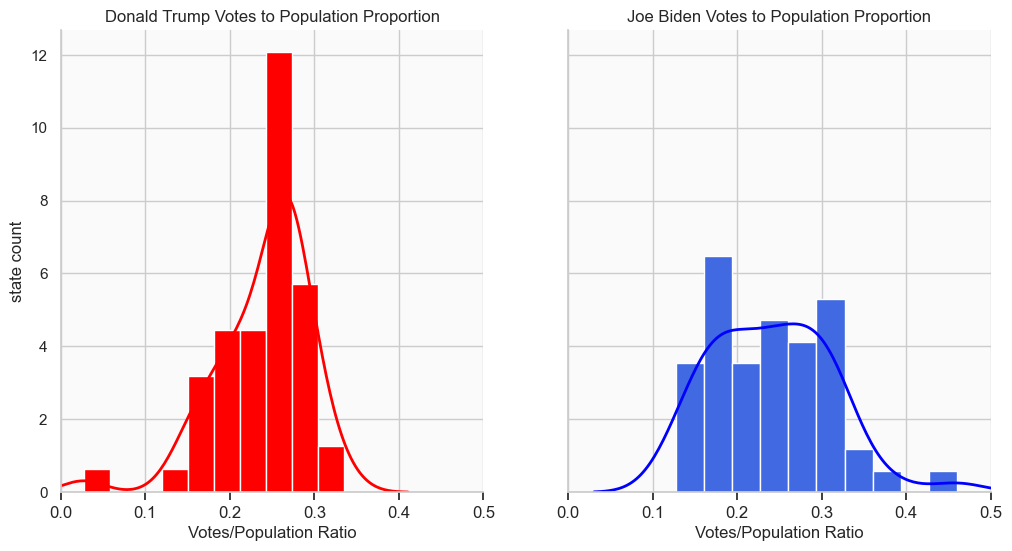

In [410]:
import scipy.stats as stats

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot the Trump's vote to population ratio histogram with a curved line in the first subplot
axs[0].hist(votes_pop_trump['Votes_Population_Proportion'], color='red', density=True)
sns.kdeplot(votes_pop_trump['Votes_Population_Proportion'], ax=axs[0], color='red', linewidth=2)
axs[0].set(xlim=(0, 0.5))
axs[0].set(title = 'Donald Trump Votes to Population Proportion', xlabel = 'Votes/Population Ratio', ylabel = 'state count')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# plot the Biden's vote to population ratio histogram with a curved line in the second subplot
axs[1].hist(votes_pop_biden['Votes_Population_Proportion'], color='royalblue', density=True)
sns.kdeplot(votes_pop_biden['Votes_Population_Proportion'], ax=axs[1], color='blue', linewidth=2)
axs[1].set(xlim=(0, 0.5))
axs[1].set(title = 'Joe Biden Votes to Population Proportion', xlabel = 'Votes/Population Ratio')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

##### The following barplot also shows the difference in the proportion between Trump and Biden in a lot of states. Just by a quick glance, Biden is dominating in the 20 states visualized below. States like ALabama, Alaska, Arkansas and Kansas where Trump recieved a greater proportion of votes when compared to the population, he indeed won in the said states. Similarly, Biden also won in the states where he receieved a higher proportion of votes including Columbia, Colorado, California and Illinois which is intuitive in itself. 

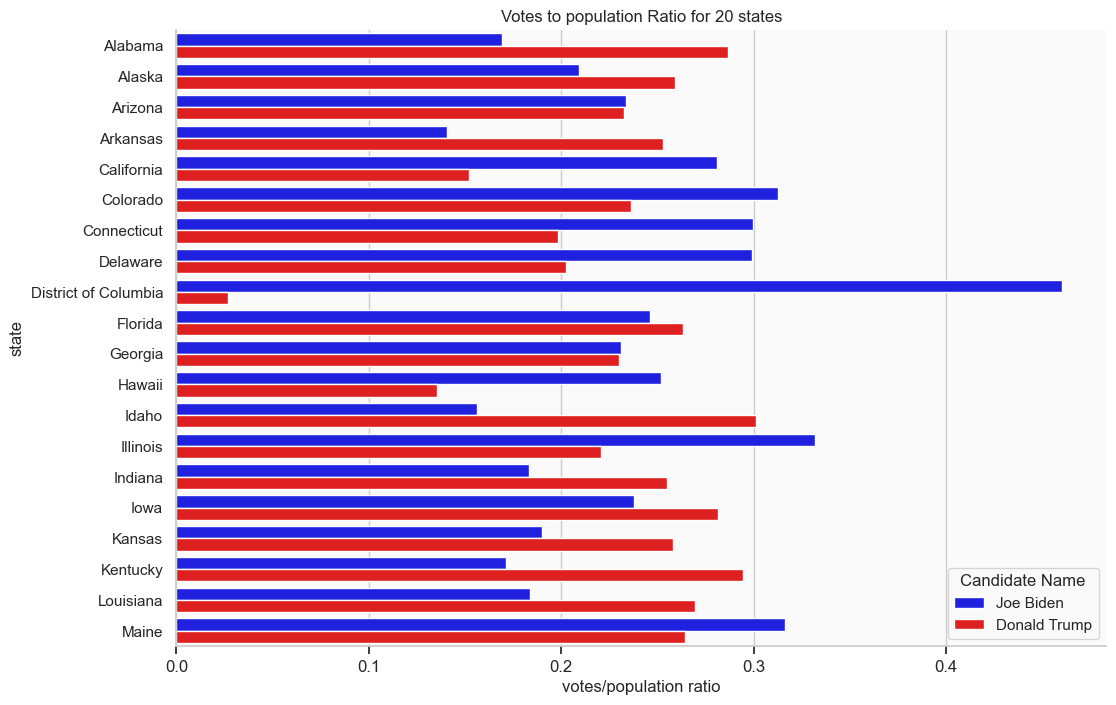

In [411]:
ax = sns.barplot(data = votes_pop.head(40), x = 'Votes_Population_Proportion', y = 'state', hue = 'Candidate Name', palette = my_palette)
ax.figure.set_size_inches(12, 8)
sns.despine()
sns.move_legend(vote_count_plot, 'lower right')
ax.set(title = 'Votes to population Ratio for 20 states', xlabel = 'votes/population ratio')
sns.move_legend(ax, 'lower right')

##### The two maps below shows the votes to population proportion of Trump and Biden for each state respectively. The whole idea of the comparison of the maps is to see the intensity of the colors. For example for any state, if Biden has a darker color comapred to the Trump, it would mean that Biden recieved a higher proportion and thus won in that state. Suppose, California (CA) has a very light red color in the Trump map while Biden has a higher intense blue color in California which would mean that Biden won in California. Simialrly, Trump recieved a higher proportion of votes in Wyoming (WY) that has a very intense red color while Biden has a very light blue color in that state which indicates that Trump must have won in Wyoming which he did!

In [412]:
fig = px.choropleth(votes_pop_trump,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='Votes_Population_Proportion',
                    color_continuous_scale=('Reds'),
                    range_color=(0.1, 0.35),
                    color_continuous_midpoint=0,
                    title = 'Votes:Population Proportion by State for Trump'
                    )

fig.add_scattergeo(
    locations=votes_pop_trump['state_code'],
    locationmode="USA-states", 
    text=votes_pop_biden['state_code'],
    mode='text'
)
fig.show()

##### The heat map below is of Biden's votes to population ratio in each state. Note that Biden has a very high ratio in Oregon (OR) as compared to Trump when the color intensity is comapred for the states. Another successful examples is Kentucky where Trump won!

In [413]:
fig = px.choropleth(votes_pop_biden,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='Votes_Population_Proportion',
                    color_continuous_scale=('blues'),
                    range_color=(0.1, 0.35),
                    color_continuous_midpoint=0,
                    title = 'Votes:Population Proportion by State for Biden'
                    )


fig.add_scattergeo(
    locations=votes_pop_biden['state_code'],
    locationmode="USA-states", 
    text=votes_pop_biden['state_code'],
    mode='text'
)
fig.show()

##### We now move to the most important task of the project. Comparing the heatmaps of the tweet count ratio with the votes-population ratio for each state by Candidate. 


##### The following code below creates a data frame by using our data frame that contains the only positive tweets of each candidate in the states. This data frame contains the number of positive tweets each candidate received in each state. The state of Northern Mariana Islands was also removed. We had to add the state_code column for convenience in mapping. Similarly, we removed the columns which were not needed for the analysis. By removing unneccessary columns, the processing time became much faster further on!  

In [414]:
tweet_count = only_positive.groupby(['state', 'Candidate Name', 'state_code']).count()
tweet_count = tweet_count.drop(columns = ['created_at', 'tweet_id', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'collected_at'])
tweet_count = tweet_count.reset_index(drop=False)
tweet_count = tweet_count.rename(columns={'tweet': 'Tweet Count'}, inplace=False)
tweet_count = tweet_count[tweet_count['state'] != 'Northern Mariana Islands']
tweet_count_1 = tweet_count.groupby('state').apply(lambda x: x['Tweet Count'].head(2).sum())
tweet_count_1 = pd.DataFrame(tweet_count_1).reset_index()
tweet_count = pd.merge(tweet_count_1, tweet_count, on ='state')
tweet_count = tweet_count.rename(columns = { 0 : 'Total Tweet Count'})
tweet_count = tweet_count.drop(columns = ['clean', 'polarity_score', 'Sentiment'])
# This data set contains the number of tweets by state for each candidate respectively

##### We now calculate and add the proportion of the tweet count of each candidate for each state. The data frame was created to show whether the tweet count proportion is a good representative of the people who actually voted. We then separated the observations and made two data frames for each candidate! 

In [415]:
tweet_count['tweet proportion'] = tweet_count['Tweet Count'] / tweet_count['Total Tweet Count']


##### We now create two separate data frames for each candidate for all the positive tweets and visualize their proportions

In [416]:
tweet_count_trump = tweet_count.loc[tweet_count['Candidate Name'] == 'Donald Trump']
tweet_count_biden = tweet_count.loc[tweet_count['Candidate Name'] == 'Joe Biden']

##### The following code creates a heat map that shows the distribution of the proportion of the positive tweets recieved by Doanld Trump in each state. When we compare this to the map of the votes population proportion map of Trump made previously, we see a similar trend in the intensity of the colors. Although there are some exceptions in a few states like Wyoming (WY), the distribution of the colors follows a specific trend in general. The proportions are difficult to judge between the two parameters due to the limitations of the data and strong assumptions. Moreover, as mentioned before the  number of tweets for Joe Biden in our data set is much larger and so, this brings in quite a big gap in the analysis!

In [417]:
fig = px.choropleth(tweet_count_trump,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='tweet proportion',
                    color_continuous_scale=('Reds'),
                    range_color=(0.25, 0.8),
                    color_continuous_midpoint=0,
                    title = 'positive tweet count proportion by State for Trump'
                    )


fig.add_scattergeo(
    locations=tweet_count_trump['state_code'],
    locationmode="USA-states", 
    text=votes_pop_biden['state_code'],
    mode='text'
)
fig.show()

##### The following code creates a heat map that shows the distribution of the proportion of the positive tweets recieved by Joe Biden in each state. When we compare this to the map of the votes population proportion map of Biden made previously there is a pattern in the intensity of the blue colors. Nevertheless, there are some anomalies in a few states like Mississipi (MS), the distribution of the colors follows a general trend in general. 

In [418]:
fig = px.choropleth(tweet_count_biden,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='tweet proportion',
                    color_continuous_scale=('blues'),
                    range_color=(0.1, 0.6),
                    color_continuous_midpoint=0,
                    title = 'positive tweet count proportion by State for Biden'
                    )


fig.add_scattergeo(
    locations=tweet_count_biden['state_code'],
    locationmode="USA-states", 
    text=votes_pop_biden['state_code'],
    mode='text'
)
fig.show()

## Merging Covid-19 Dataset

##### In this part of the project, I decided to view the 2020 elections from a different lens. We know that the elections were held during the COVID-19 pandemic. I inferred that the pandemic must have affected the eletion in some way, either in support of Biden or against Trump which resulted in Biden to win the elections. After some external research regarding COVID-19 in the United States I saw that Biden had much favorable policies related to health. Biden promised better healthcare reforms comapred to Trump so I hypothesized that the states that had a higher number of covid cases ended up supporting Biden. We already had the map for positive sentiment for Biden and Trump respectively from our previous projects and a comparison of the maps would certainly be helpful to prove my hypothesis. For this purpose I looked up and found out the data set that contains the the covid-19 statistics of USA.   

##### The following code reads the dataset that originally contained the US COVID-19 cases and deaths by state over time. The data contained over 60000 observations and data cleaning was neccessary. Note that We needed the data of the statistics of covid-19 which occured before the election date, November 3rd 2020. So, we first removed all the observations that had na values for the submission date. We then change the date time in the data frame to the correct python format. We then filtered all the observations with the dates that were pre-election. After removing the na values for total cases column, we sorted values for state and submission date. We then used the first() method to collect the first 50 rows of each state for thet election date. Note that these observations would have the total number of cases (cumulative since the first case observed) for each state by the election date. We finally removed all the unnecessary columns from the data frame. 

In [464]:
covid_cases = pd.read_csv(r"C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_-_ARCHIVED.csv")
covid_cases = covid_cases.dropna(subset = ['submission_date'])
covid_cases['submission_date'] = pd.to_datetime(covid_cases['submission_date'])
covid_cases = covid_cases.query('submission_date <= "11/3/2020"')
covid_cases = covid_cases.query('submission_date >= "10/15/2020"')
covid_cases = covid_cases.dropna(subset= ['tot_cases', 'tot_death'])
covid_cases_state = covid_cases.sort_values(['state', 'submission_date'], ascending = [True, True])
covid_cases_state = covid_cases_state.groupby('state').first()
covid_cases_state = covid_cases_state.drop(columns = ['conf_cases', 'prob_cases', 'new_case',
       'pnew_case', 'conf_death', 'prob_death', 'new_death',
       'pnew_death', 'created_at', 'consent_cases', 'consent_deaths'])

covid_cases_state = covid_cases_state.reset_index()

##### We furthee cleaned the data with some state names that were miscellaneous and also renamed the columns for convenience in merging and mapping. We also sorted values of the state alphabetically for convenience. Since total cases was a string object we hd to convert into integers as done by the folowing code below. We finally merge our data set with the state_code data set for it to contain the state names

In [468]:
covid_cases_state = covid_cases_state[~covid_cases_state['state'].isin(['AS', 'RMI', 'FSM', 'PR', 'GU', 'MP', 'NYC', 'PW', 'VI'])]
covid_cases_state = covid_cases_state.rename(columns={'state': 'state_code'}, inplace=False)
covid_cases_state = covid_cases_state.sort_values('state_code')
covid_cases_state['tot_cases'] = covid_cases_state['tot_cases'].str.replace(',', '')
covid_cases_state['tot_cases'] = covid_cases_state['tot_cases'].astype(int)
covid_cases_state = pd.merge(state_code, covid_cases_state, on = 'state_code')

##### The following code creates a data frame that contains the states with the highest number total covid cases. The bar plot below shows the top ten higehst states with the highest number of covid cases where Texas,  California and Florida had over 800k cases. Although Trump won in Texas making it an aomaly, Biden won in most states mentioned in the barplot below including California, Illinois, Georgia adn New Jersey. Although Biden lost in states like Texas, Florida, and North Carolina it is to be noted that all these were battle ground states where the competition was very fierce and Trump won with only a small margin. 

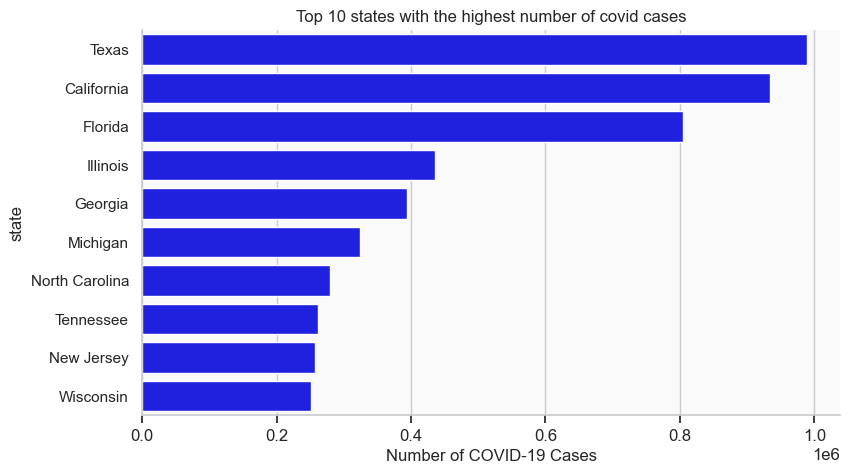

In [421]:
covid_cases_state_high = covid_cases_state.sort_values('tot_cases', ascending = False)
covid_cases_state_high = covid_cases_state_high.head(10)
ax = sns.barplot(x = 'tot_cases', y = 'state', data = covid_cases_state_high, color = 'blue')
ax.set_title('Top 10 states with the highest number of covid cases')
ax.set_xlabel('Number of COVID-19 Cases')
ax.set_ylabel('state')
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False})
ax.figure.set_size_inches(9, 5)
sns.despine()


##### The following code sorts values in a descending order to see states with the lowest number of cases. Note that the small states like New Jersey, Connecticut and Maine had very low number of COVID cases due to its low population so, it was inevitable that there COVID cases would have been low as well. Since, large states like Texas and California had highest number of cases, I took medium size states. We see that states like Arkansas, Kansas, Nebraska and South and North Dakota  had less COVID cases compared to states like California and North Carolina and so, people preferred Trump since, they didn't face COVID-19 with the same intensity so they had less preference on strong health policies and reforms. This matches our hypotheses!

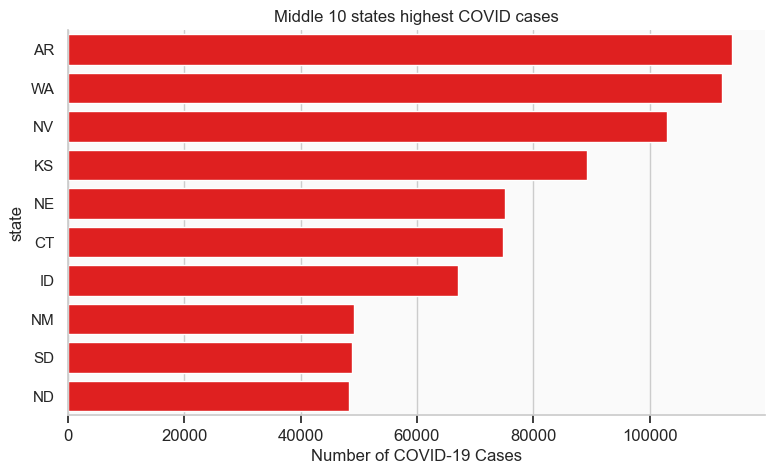

In [422]:
covid_cases_state_low = covid_cases_state.sort_values('tot_cases', ascending = False)
covid_cases_state_low = covid_cases_state_low.iloc[29:-12]
ax = sns.barplot(x = 'tot_cases', y = 'state_code', data = covid_cases_state_low, color = 'red')
ax.set_xlabel('Number of COVID-19 Cases')
ax.set_ylabel('state')
ax.set_title('Middle 10 states highest COVID cases')
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False})
ax.figure.set_size_inches(9, 5)
sns.despine()

##### The following code below shows a heat map with the covid cases of all states. We see that the states with high number of cases (dark green regions) Biden recieved a high average positive tweet sentiment as well as the votes population proportion. States like California, Pennsylvania and New York recieved high average positive sentiment as well as high total cases and so, Biden ended up winning int he aforementioned states!

In [444]:
covid_cases_state.head()

,state,state_code,submission_date,tot_cases,tot_death
0,Oregon,OR,2020-11-03,46460,701
1,District of Columbia,DC,2020-11-03,17524,647
2,California,CA,2020-11-03,934672,"17,692"
3,Ohio,OH,2020-11-03,226138,"5,373"
4,Pennsylvania,PA,2020-11-03,221560,"8,855"


In [423]:
fig = px.choropleth(covid_cases_state,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='tot_cases',
                    range_color = (20000,200000),
                    color_continuous_scale=('algae'),
                    color_continuous_midpoint=0,
                    title = 'Total number of Covid-19 cases until election'
                    )


fig.add_scattergeo(
    locations= covid_cases_state['state_code'],
    locationmode="USA-states", 
    text= covid_cases_state['state_code'],
    mode='text',
    textfont=dict(color='#664400')
)
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Total Cases"
    ))
fig.show()

## Conclusion
##### The project essentially aimed to demonstrate the relationship between different variables that kept the public enagaged in social media platforms like Twitter and share their opinions in different ways. Some people like tweets while others can retweet it to show their support or interest towards an idea. This activity of liking and retweeting can significantly reflect people's emotions at a certain time or in a certain region. Sentiment Analysis helped identify which states were happy to support Biden or Trump pretty straighforwardly. The Statistics tables indicated on average how much people were interested in the campaign and how many likes and retweet counts was each candidate receiving. Moreover, the comparison of only positive tweets with regular tweets also illustrated the differences in public engagement on such tweets. We could have used the negative sentiment (we would expect the relationship between variables to be the opposite) tweets as well but it would have made the analysis unbalance. 

##### The plots were also a good way to visualize which candidate was provoking more public engagement in certain states. We used the top 20 states with highest averages to check which candidate was winning. Most of the States mentioned in the bar plots, Biden was the one with more engagement on twitter due to high number of likes and retweets. Thus, without a doubt Biden was the final winner. Similarly, the scatter plots demostrated that vote counts and average likes had some sort of weak relation. Moreover, there were clusters in both the average likes and avergae retweet count plots showing that both variables moved together.

##### The maps took the analysis to a much deeper level since it demonstrated how the results of many states were accurately predicted just based on the the intensity of the positive or negative sentiment each candidate received in every state. The higher the positivity score or the lower the negativity score the higher the chance for the candidate to win in that state and vice versa. 
##### Although there were some contradictions when it came to predicting states, we can calculate the proportion of the sentiment scores to know the relative share of positivity or negativity of a candidate in each state. This can easily decrease our error specially if we compare the scores with the relative vote share in each state of the candidates. It can easily show how close our sentiment analysis was with real life election results.

C:\Users\danis\AppData\Local\Temp\ipykernel_25672\862284172.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



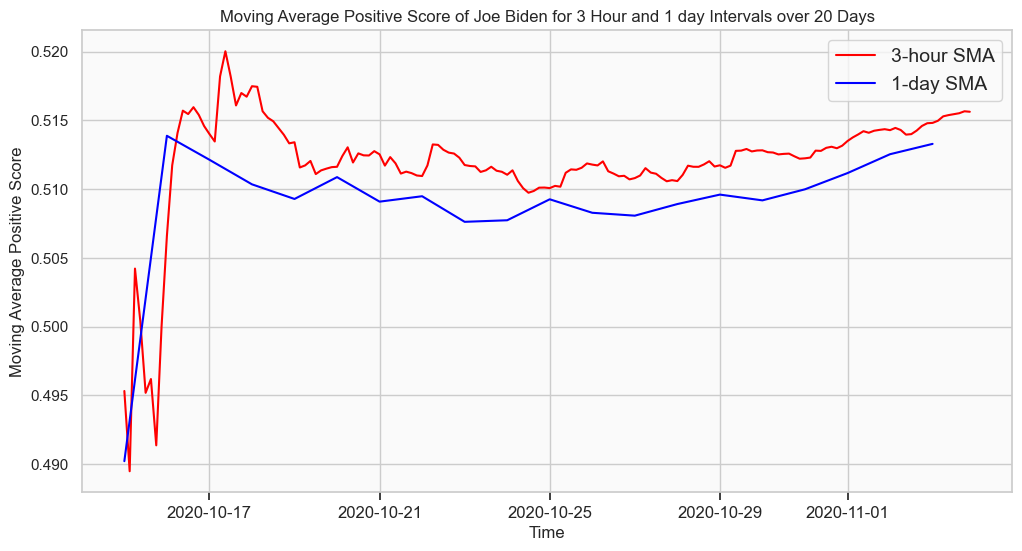

In [424]:
state_opb = state_op.loc[state_op['Candidate Name'] == 'Joe Biden']
# Load the time series data into a DataFrame and convert 'created_at' column to datetime format
state_opb['created_at'] = pd.to_datetime(state_opb['created_at'])

# Set 'created_at' column as the index
state_opb = state_opb.set_index('created_at')

# Calculate the mean negative score for each 30-minute interval
pos_scores_1 = state_opb['positive'].resample('180T').mean()
pos_scores_2 = state_opb['positive'].resample('1440T').mean()

# Calculate the rolling 20-day moving average of the mean negative score
rolling_avg_1 = pos_scores_1.rolling('20D').mean()
rolling_avg_2 = pos_scores_2.rolling('20D').mean()

# Plot the rolling average on a graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rolling_avg_1, color='red', linewidth=1.5)
ax.plot(rolling_avg_2, color = 'blue', linewidth = 1.5)

# Set the axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Moving Average Positive Score')
ax.set_title('Moving Average Positive Score of Joe Biden for 3 Hour and 1 day Intervals over 20 Days')
ax.legend(labels =['3-hour SMA', '1-day SMA'], fontsize=14)

plt.show()

C:\Users\danis\AppData\Local\Temp\ipykernel_25672\951608682.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



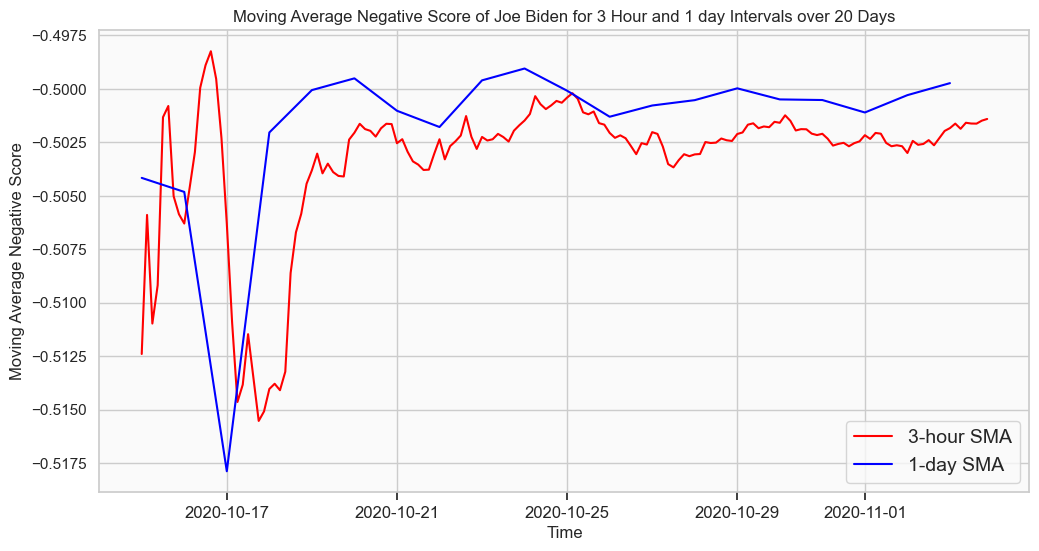

In [425]:
state_onb = state_on.loc[state_on['Candidate Name'] == 'Joe Biden']
# Load the time series data into a DataFrame and convert 'created_at' column to datetime format
state_onb['created_at'] = pd.to_datetime(state_onb['created_at'])

# Set 'created_at' column as the index
state_onb = state_onb.set_index('created_at')

# Calculate the mean negative score for each 30-minute interval
neg_scores_3hr = state_onb['negative'].resample('180T').mean()
neg_scores_24hr = state_onb['negative'].resample('1440T').mean()

# Calculate the rolling 20-day moving average of the mean negative score
rolling_avg_1 = neg_scores_3hr.rolling('20D').mean()
rolling_avg_2 = neg_scores_24hr.rolling('20D').mean()

# Plot the rolling average on a graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rolling_avg_1, color='red', linewidth = 1.5)
ax.plot(rolling_avg_2, color = 'blue', linewidth = 1.5)
# Set the axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Moving Average Negative Score')
ax.set_title('Moving Average Negative Score of Joe Biden for 3 Hour and 1 day Intervals over 20 Days')
ax.legend(labels =['3-hour SMA', '1-day SMA'], fontsize=14)

plt.show()


C:\Users\danis\AppData\Local\Temp\ipykernel_25672\747532126.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



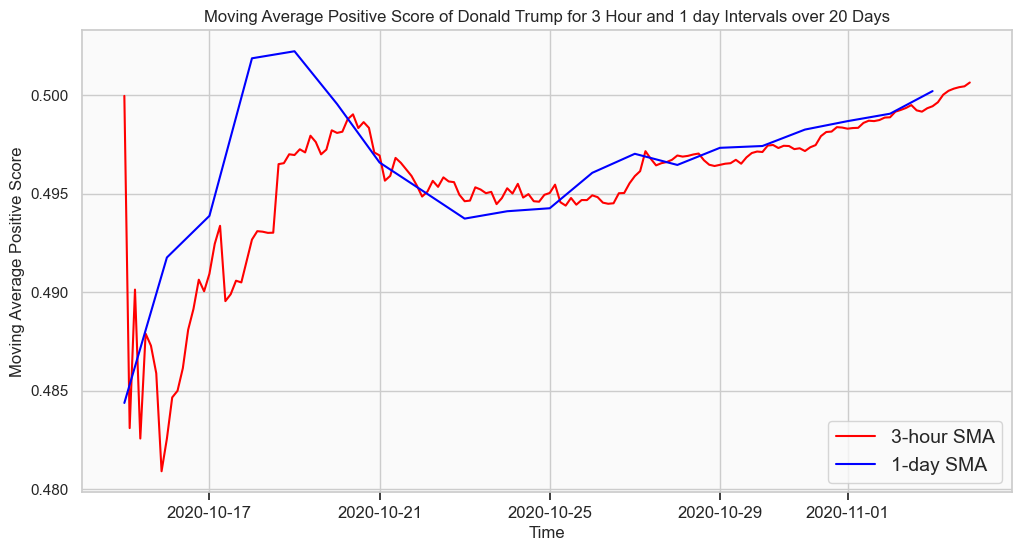

In [426]:
state_opt = state_op.loc[state_op['Candidate Name'] == 'Donald Trump']
# Load the time series data into a DataFrame and convert 'created_at' column to datetime format
state_opt['created_at'] = pd.to_datetime(state_opt['created_at'])

# Set 'created_at' column as the index
state_opt = state_opt.set_index('created_at')

# Calculate the mean negative score for each 30-minute interval
pos_scores_3hr = state_opt['positive'].resample('180T').mean()
pos_scores_24hr = state_opt['positive'].resample('1440T').mean()

# Calculate the rolling 20-day moving average of the mean negative score
rolling_avg_1 = pos_scores_3hr.rolling('20D').mean()
rolling_avg_2 = pos_scores_24hr.rolling('20D').mean()

# Plot the rolling average on a graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rolling_avg_1, color='red', linewidth=1.5)
ax.plot(rolling_avg_2, color = 'blue', linewidth = 1.5)
# Set the axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Moving Average Positive Score')
ax.set_title('Moving Average Positive Score of Donald Trump for 3 Hour and 1 day Intervals over 20 Days')

ax.legend(labels =['3-hour SMA', '1-day SMA'], fontsize=14)

plt.show()

C:\Users\danis\AppData\Local\Temp\ipykernel_25672\1719097422.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



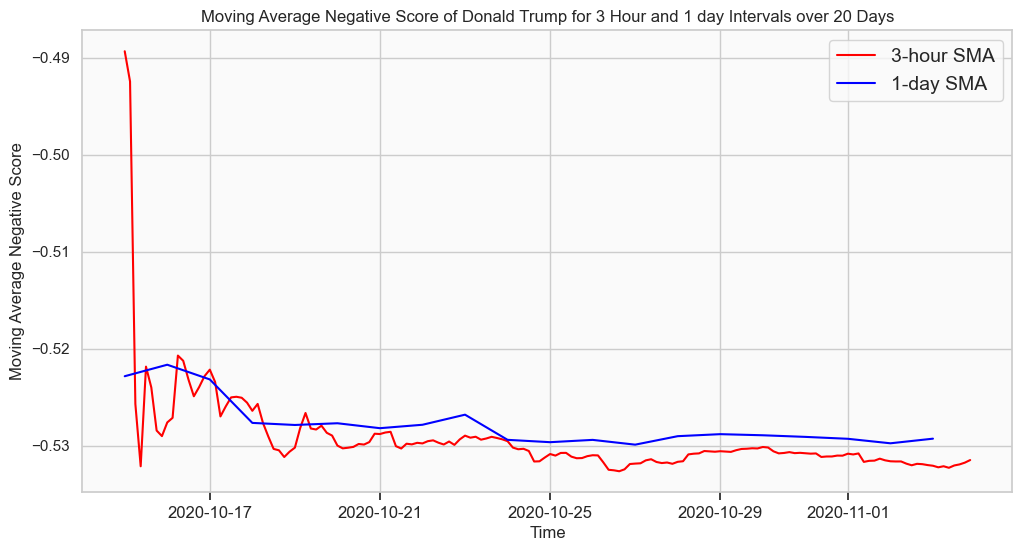

In [427]:
state_ont = state_on.loc[state_on['Candidate Name'] == 'Donald Trump']
# Load the time series data into a DataFrame and convert 'created_at' column to datetime format
state_ont['created_at'] = pd.to_datetime(state_ont['created_at'])

# Set 'created_at' column as the index
state_ont = state_ont.set_index('created_at')

# Calculate the mean negative score for each 30-minute interval
neg_scores_3hr = state_ont['negative'].resample('180T').mean()
neg_scores_24hr = state_ont['negative'].resample('1440T').mean()
# Calculate the rolling 20-day moving average of the mean negative score
rolling_avg_1 = neg_scores_3hr.rolling('20D').mean()
rolling_avg_2 = neg_scores_24hr.rolling('20D').mean()
# Plot the rolling average on a graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rolling_avg_1, color='red', linewidth=1.5)
ax.plot(rolling_avg_2, color = 'blue', linewidth = 1.5)

# Set the axis labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Moving Average Negative Score')
ax.set_title('Moving Average Negative Score of Donald Trump for 3 Hour and 1 day Intervals over 20 Days')

ax.legend(labels =['3-hour SMA', '1-day SMA'], fontsize=14)
# Display the graph
plt.show()



In [428]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
reg1 = sm.OLS(endog=mean_pos_table['total_votes'], exog=mean_pos_table['user_followers_count'], # endogenous is y variable and exogenous is x variable
             missing = 'drop')
results = reg1.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            total_votes   R-squared (uncentered):                   0.376
Model:                            OLS   Adj. R-squared (uncentered):              0.364
Method:                 Least Squares   F-statistic:                              30.14
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                    1.34e-06
Time:                        03:04:49   Log-Likelihood:                         -805.12
No. Observations:                  51   AIC:                                      1612.
Df Residuals:                      50   BIC:                                      1614.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [443]:
state_onb = state_onb.reset_index()
state_onb.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,country,continent,state,state_code,collected_at,Candidate Name,clean,polarity_score,Sentiment,negative
0,2020-10-15 00:02:41,1.316530e+18,"@Twitter, since you are censoring free speech,...",0.0,0.0,Twitter for Android,1.251413e+18,Gen X James,GenXJames1,"I'm a non apologetic, non Millennial.\nI am a ...",...,United States of America,North America,Minnesota,MN,2020-10-21 00:00:19.677436754,Joe Biden,since you are censoring free speech regards em...,"{'neg': 0.204, 'neu': 0.66, 'pos': 0.136, 'com...",Negative,-0.1620
1,2020-10-15 00:02:50,1.316530e+18,Has this awoken you from your slumbers yet @BB...,1.0,0.0,Twitter for iPhone,5.667098e+07,malcolm cowing,MalcolmCowing,Retired former Managing Partner of marcoms age...,...,United States of America,North America,Virginia,VA,2020-10-21 00:00:21.748745887,Joe Biden,has this awoken you your slumbers yet getting ...,"{'neg': 0.188, 'neu': 0.812, 'pos': 0.0, 'comp...",Negative,-0.5719
2,2020-10-15 00:03:17,1.316530e+18,"Hunter #Biden introduced his father, then-Vice...",1.0,0.0,Twitter for Android,1.936873e+08,Gaminglawyer,GamingLawyer,Legal & Business Services 4 Online Gaming & Ga...,...,United States of America,North America,New York,NY,2020-10-21 00:00:27.444846,Joe Biden,hunter introduced his father then vice preside...,"{'neg': 0.113, 'neu': 0.785, 'pos': 0.102, 'co...",Negative,-0.1027
3,2020-10-15 00:04:40,1.316530e+18,The reason why Twitter has locked the New York...,0.0,0.0,Twitter for iPhone,3.112087e+09,Complete Christianity,ShaneSchaetzel,"Catholic Convert & Apologist, Catechist, Autho...",...,United States of America,North America,Arkansas,AR,2020-10-21 00:00:38.319218943,Joe Biden,reason why twitter has locked new york post ac...,"{'neg': 0.193, 'neu': 0.807, 'pos': 0.0, 'comp...",Negative,-0.7351
4,2020-10-15 00:05:04,1.316530e+18,Laptop computer abandoned at Delaware repair s...,1.0,1.0,Twitter Web App,9.114597e+07,H L Wegley,hlwegley,Meteorologist & Comp Sci guy who writes novels...,...,United States of America,North America,Washington,WA,2020-10-21 00:00:40.390528075,Joe Biden,laptop computer abandoned at delaware repair s...,"{'neg': 0.148, 'neu': 0.852, 'pos': 0.0, 'comp...",Negative,-0.5719
